Load in packages and data
-

In [2]:
#packages
import numpy as np
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import timedelta
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
from scipy.stats import anderson
from scipy.stats import probplot
import statsmodels.api as sm
import statsmodels
from statsmodels.graphics.gofplots import qqplot_2samples
import seaborn as sns

In [3]:
#data
log = pm4py.read_xes('data/data/logs/omron/omron.xes')

c:\Users\20183207\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 262/262 [00:27<00:00,  9.60it/s]
c:\Users\20183207\AppData\Local\Programs\Python\Python311\Lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
c:\Users\20183207\AppData\Local\Programs\Python\Python311\Lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, p

Preparing main tables
-

In [4]:
#put data into dataframe
log = log.rename(columns={"concept:name": "events", "operator":"operator", "product_id":"product_id", "time:timestamp":"time:timestamp","time:start_time":"time:start_time", "time:stop_time":"time:stop_time"})
log.head()

,events,operator,product_id,time:timestamp,time:start_time,time:stop_time
0,Insert,0,400016704_0009,2020-01-09 11:03:24.071000+00:00,2020-01-09 11:03:24.071000+00:00,2020-01-09 11:03:24.071000+00:00
1,CBP-WPPs,0,400016704_0009,2020-01-09 11:03:24.071000+00:00,2020-01-09 11:03:24.071000+00:00,2020-01-09 11:03:24.071000+00:00
2,CBP-WPPc,0,400016704_0009,2020-01-09 11:52:30.496000+00:00,2020-01-09 11:52:30.496000+00:00,2020-01-09 11:52:30.496000+00:00
3,CBP-FS,0,400016704_0009,2020-01-09 11:52:31.004000+00:00,2020-01-09 11:52:31.004000+00:00,2020-01-09 11:52:31.004000+00:00
4,CBP-FS,0,400016704_0009,2020-01-09 11:52:31.531000+00:00,2020-01-09 11:52:31.530000+00:00,2020-01-09 11:52:31.531000+00:00


In [5]:
#add stages
stages = pd.DataFrame()
stages['events'] = pd.DataFrame(log["events"].unique())
stages['stage'] = pd.DataFrame([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 5, 4, 4, 5, 5, 5, 5, 5, 6, 5, 7, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7])

#combine log and stages into main dataframe
main = pd.merge(log, stages, on='events')
main.head()

,events,operator,product_id,time:timestamp,time:start_time,time:stop_time,stage
0,Insert,0,400016704_0009,2020-01-09 11:03:24.071000+00:00,2020-01-09 11:03:24.071000+00:00,2020-01-09 11:03:24.071000+00:00,1
1,Insert,0,400016704_0010,2020-01-09 11:59:18.848000+00:00,2020-01-09 11:59:18.848000+00:00,2020-01-09 11:59:18.848000+00:00,1
2,Insert,0,400016703_0007,2020-01-10 05:39:04.046000+00:00,2020-01-10 05:39:04.046000+00:00,2020-01-10 05:39:04.046000+00:00,1
3,Insert,0,400016703_0011,2020-01-10 07:41:39.813000+00:00,2020-01-10 07:41:39.813000+00:00,2020-01-10 07:41:39.813000+00:00,1
4,Insert,0,400016703_0012,2020-01-10 07:53:19.074000+00:00,2020-01-10 07:53:19.074000+00:00,2020-01-10 07:53:19.074000+00:00,1


Adding redos based on ordered data

In [6]:
#order data 
mainOrder =  main.sort_values(by=['product_id', 'time:start_time'])

In [7]:
#each product should go through each event once, so first
#check duplicates for event and product_id combination
mainOrder.duplicated(subset=["events", "product_id"])

#add column that says true if the event is a redo
mainOrder['redo'] = pd.DataFrame(mainOrder.duplicated(subset=["events", "product_id"]))

#add exceptions for events that are allowed to happen multiple times
mainOrder['redo'].mask(mainOrder['events'] == 'CBP-FS', False, inplace=True)
mainOrder['redo'].mask(mainOrder['events'] == 'IA-WCSs', False, inplace=True)
mainOrder['redo'].mask(mainOrder['events'] == 'IA-WCSc', False, inplace=True)
mainOrder.head()

,events,operator,product_id,time:timestamp,time:start_time,time:stop_time,stage,redo
15,Insert,0,400016698_0001,2020-01-13 14:09:17.230000+00:00,2020-01-13 14:09:17.230000+00:00,2020-01-13 14:09:17.230000+00:00,1,False
455330,P-WSs,0,400016698_0001,2020-01-13 14:09:17.230000+00:00,2020-01-13 14:09:17.230000+00:00,2020-01-13 14:09:17.230000+00:00,7,False
539190,P-WSc,0,400016698_0001,2020-01-13 14:12:06.669000+00:00,2020-01-13 14:12:06.669000+00:00,2020-01-13 14:12:06.669000+00:00,7,False
548827,P-AP,0,400016698_0001,2020-01-13 14:12:07.689000+00:00,2020-01-13 14:12:07.178000+00:00,2020-01-13 14:12:07.689000+00:00,7,False
558464,P-L>2,0,400016698_0001,2020-01-13 14:12:08.195000+00:00,2020-01-13 14:12:08.195000+00:00,2020-01-13 14:12:08.195000+00:00,7,False


In [8]:
#add column that counts redos to keep rows unique in other dataframes
mainOrder['combination_count'] = mainOrder.groupby(['product_id', 'events']).cumcount() + 1

Calculation waiting time
-

In [9]:
#put all time data in different dataframe to calculate with
timeIn = pd.DataFrame()
timeIn['product_id'] = pd.DataFrame(mainOrder['product_id'])
timeIn['events'] = pd.DataFrame(mainOrder['events'])
timeIn['stage'] = pd.DataFrame(mainOrder['stage'])
timeIn['start_time'] = pd.DataFrame(mainOrder['time:start_time'])
timeIn['stop_time'] = pd.DataFrame(mainOrder['time:stop_time'])
timeIn['redo'] = pd.DataFrame(mainOrder['redo'])
timeIn['combination_counter'] = pd.DataFrame(mainOrder['combination_count'])
#order the dataframe again to be sure it is still ordered
timeIn = timeIn.sort_values(by=['product_id', 'start_time'])

In [10]:
#select checkpoints to calculate waiting time after stage 1
startwait = []
stopwait = []
productId = []
redo = []
cumcount = []
comingfrom = []
a=0
b=0
p=0

for row in timeIn.itertuples():
    if row.events=='CBP-WSFc':
        a = row.stop_time
        p = row.product_id
        e = row.combination_counter
        f = row.redo
    elif row.events=='CB-WSc' and row.product_id==p:
        b = row.start_time
        startwait.append(a)
        stopwait.append(b)
        productId.append(p)
        redo.append(row.redo)
        cumcount.append(e)
        comingfrom.append(f)
        p = 0

#convert lists of checkpoints to dataframe
waitone = pd.DataFrame()
waitone['product_id'] = productId
waitone['startwait_1'] = startwait
waitone['stopwait_1'] = stopwait
waitone['going_to_redo_1'] = redo
waitone['combination_counter'] = cumcount
waitone['coming_from_redo_1'] = comingfrom

#calculate waittime
waitone['after_1']=waitone['stopwait_1']-waitone['startwait_1']

In [11]:
#after stage 2
startwait = []
stopwait = []
productId = []
redo = []
cumcount = []
comingfrom = []
a=0
b=0
p=0

for row in timeIn.itertuples():
    if row.events=='CB-WSFc':
        a = row.stop_time
        p = row.product_id
        e = row.combination_counter
        f = row.redo
    elif (row.events=='IA-WSc' or row.events=='CB-WSc') and row.product_id==p:
        b = row.start_time
        startwait.append(a)
        stopwait.append(b)
        productId.append(p)
        redo.append(row.redo)
        cumcount.append(e)
        comingfrom.append(f)
        p = 0
        
#convert lists to dataframe
waittwo = pd.DataFrame()
waittwo['product_id'] = productId
waittwo['startwait_2'] = startwait
waittwo['stopwait_2'] = stopwait
waittwo['going_to_redo_2'] = redo
waittwo['combination_counter'] = cumcount
waittwo['coming_from_redo_2'] = comingfrom

#calculate waittime
waittwo['after_2']=waittwo['stopwait_2']-waittwo['startwait_2']

In [12]:
#after stage 3
startwait = []
stopwait = []
productId = []
redo = []
cumcount = []
comingfrom = []
a=0
b=0
p=0

for row in timeIn.itertuples():
    if row.events=='IA-WSFc':
        a = row.stop_time
        p = row.product_id
        e = row.combination_counter
        f = row.redo
    elif (row.events=='OFC-WPPc' or row.events=='IA-WSc' or row.events=='CB-WSc') and row.product_id==p:
        b = row.start_time
        startwait.append(a)
        stopwait.append(b)
        productId.append(p)
        redo.append(row.redo)
        cumcount.append(e)
        comingfrom.append(f)
        p = 0
        
#convert lists to dataframe
waitthree = pd.DataFrame()
waitthree['product_id'] = productId
waitthree['startwait_3'] = startwait
waitthree['stopwait_3'] = stopwait
waitthree['going_to_redo_3'] = redo
waitthree['combination_counter'] = cumcount
waitthree['coming_from_redo_3'] = comingfrom

#calculate waittime
waitthree['after_3']=waitthree['stopwait_3']-waitthree['startwait_3']

In [13]:
#after stage 4
startwait = []
stopwait = []
productId = []
redo = []
cumcount = []
comingfrom = []
a=0
b=0
p=0

for row in timeIn.itertuples():
    if row.events=='OFC-GT':
        a = row.stop_time
        p = row.product_id
        e = row.combination_counter
        f = row.redo
    elif (row.events=='OA-WSc' or row.events=='OFC-WPPc' or row.events=='IA-WSc' or row.events=='CB-WSc') and row.product_id==p:
        b = row.start_time
        startwait.append(a)
        stopwait.append(b)
        productId.append(p)
        redo.append(row.redo)
        cumcount.append(e)
        comingfrom.append(f)
        p = 0
        
#convert lists to dataframe
waitfour = pd.DataFrame()
waitfour['product_id'] = productId
waitfour['startwait_4'] = startwait
waitfour['stopwait_4'] = stopwait
waitfour['going_to_redo_4'] = redo
waitfour['combination_counter'] = cumcount
waitfour['coming_from_redo_4'] = comingfrom

#calculate waittime
waitfour['after_4']=waitfour['stopwait_4']-waitfour['startwait_4']

In [14]:
#after stage 5
startwait = []
stopwait = []
productId = []
redo = []
cumcount = []
comingfrom = []
a=0
b=0
p=0

for row in timeIn.itertuples():
    if row.events=='OA-WSFc':
        a = row.stop_time
        p = row.product_id
        e = row.combination_counter
        f = row.redo
    elif (row.events=='FC-WPPc' or row.events=='OA-WSc' or row.events=='OFC-WPPc' or row.events=='IA-WSc' or row.events=='CB-WSc') and row.product_id==p:
        b = row.start_time
        startwait.append(a)
        stopwait.append(b)
        productId.append(p)
        redo.append(row.redo)
        cumcount.append(e)
        comingfrom.append(f)
        p = 0
        
#convert lists to dataframe
waitfive = pd.DataFrame()
waitfive['product_id'] = productId
waitfive['startwait_5'] = startwait
waitfive['stopwait_5'] = stopwait
waitfive['going_to_redo_5'] = redo
waitfive['combination_counter'] = cumcount
waitfive['coming_from_redo_5'] = comingfrom

#calculate waittime
waitfive['after_5']=waitfive['stopwait_5']-waitfive['startwait_5']

In [15]:
#after stage 6
startwait = []
stopwait = []
productId = []
redo = []
cumcount = []
comingfrom = []
a=0
b=0
p=0

for row in timeIn.itertuples():
    if row.events=='FC-GT':
        a = row.stop_time
        p = row.product_id
        e = row.combination_counter
        f = row.redo
    elif (row.events=='P-WSc' or row.events=='FC-WPPc' or row.events=='OA-WSc' or row.events=='OFC-WPPc' or row.events=='IA-WSc' or row.events=='CB-WSc') and row.product_id==p:
        b = row.start_time
        startwait.append(a)
        stopwait.append(b)
        productId.append(p)
        redo.append(row.redo)
        cumcount.append(e)
        comingfrom.append(f)
        p = 0
        
#convert lists to dataframe
waitsix = pd.DataFrame()
waitsix['product_id'] = productId
waitsix['startwait_6'] = startwait
waitsix['stopwait_6'] = stopwait
waitsix['going_to_redo_6'] = redo
waitsix['combination_counter'] = cumcount
waitsix['coming_from_redo_6'] = comingfrom

#calculate waittime
waitsix['after_6']=waitsix['stopwait_6']-waitsix['startwait_6']

In [16]:
#after stage 7, only for redos occurring after stage 7
startwait = []
stopwait = []
productId = []
redo = []
cumcount = []
comingfrom = []
a=0
b=0
p=0

for row in timeIn.itertuples():
    if row.events=='P-WSFc':
        a = row.stop_time
        p = row.product_id
        e = row.combination_counter
        f = row.redo
    elif (row.events=='P-WSc' or row.events=='FC-WPPc' or row.events=='OA-WSc' or row.events=='OFC-WPPc' or row.events=='IA-WSc' or row.events=='CB-WSc') and row.product_id==p:
        b = row.start_time
        startwait.append(a)
        stopwait.append(b)
        productId.append(p)
        redo.append(row.redo)
        cumcount.append(e)
        comingfrom.append(f)
        p = 0
        
#convert lists to dataframe
waitsev = pd.DataFrame()
waitsev['product_id'] = productId
waitsev['startwait_7'] = startwait
waitsev['stopwait_7'] = stopwait
waitsev['going_to_redo_7'] = redo
waitsev['combination_counter'] = cumcount
waitsev['coming_from_redo_7'] = comingfrom

#calculate waittime
waitsev['after_7']=waitsev['stopwait_7']-waitsev['startwait_7']

Make one dataframe with cumulative waiting times\
To avoid nans, all wait times are summed after each stage per product id, and then put together in a dataframe. To further avoid nans the waiting time for after the last stage is the wait time for after the sixth stage, with the waiting time of the redos added on. 

First sum all waiting times per product after each stage

In [17]:
#to be sure order waitone per productid
order1 = waitone.sort_values(by='product_id')

#sum wait per product id
productId = []
cwait = []
going = []
p=order1['product_id'][0]
g=order1['going_to_redo_1'][0]
c=timedelta(days=0, hours=0, minutes=0)

for row in order1.itertuples():
    if row.product_id == p:
        c = c + row.after_1
    else:
        cwait.append(c)
        productId.append(p)
        going.append(g)
        g=row.going_to_redo_1
        p=row.product_id
        c = timedelta(days=0, hours=0, minutes=0)
        c = c + row.after_1 
        
#convert lists to dataframe
cwaitone = pd.DataFrame()
cwaitone['product_id'] = productId
cwaitone['going_to_redo_1'] = going
cwaitone['cafter_1'] = cwait

In [18]:
#to be sure order wait per productid
order2 = waittwo.sort_values(by='product_id')

#sum wait for product id
productId = []
cwait = []
going = []
p=order2['product_id'][0]
g=order2['going_to_redo_2'][0]
c=timedelta(days=0, hours=0, minutes=0)

for row in order2.itertuples():
    if row.product_id == p:
        c = c + row.after_2
    else:
        cwait.append(c)
        productId.append(p)
        going.append(g)
        g=row.going_to_redo_2
        p=row.product_id
        c = timedelta(days=0, hours=0, minutes=0)
        c = c + row.after_2
        
#convert lists to dataframe
cwaittwo = pd.DataFrame()
cwaittwo['product_id'] = productId
cwaittwo['going_to_redo_2'] = going
cwaittwo['cafter_2'] = cwait

In [19]:
#to be sure order wait per productid
order3 = waitthree.sort_values(by='product_id')

#sum wait for product id
productId = []
cwait = []
going = []
p=order3['product_id'][0]
g=order3['going_to_redo_3'][0]
c=timedelta(days=0, hours=0, minutes=0)

for row in order3.itertuples():
    if row.product_id == p:
        c = c + row.after_3
    else:
        cwait.append(c)
        productId.append(p)
        going.append(g)
        g=row.going_to_redo_3
        p=row.product_id
        c = timedelta(days=0, hours=0, minutes=0)
        c = c + row.after_3
        
#convert lists to dataframe
cwaitthree = pd.DataFrame()
cwaitthree['product_id'] = productId
cwaitthree['going_to_redo_3'] = going
cwaitthree['cafter_3'] = cwait

In [20]:
#to be sure order wait per productid
order4 = waitfour.sort_values(by='product_id')

#sum wait for product id
productId = []
cwait = []
going = []
p=order4['product_id'][0]
g=order4['going_to_redo_4'][0]
c=timedelta(days=0, hours=0, minutes=0)

for row in order4.itertuples():
    if row.product_id == p:
        c = c + row.after_4
    else:
        cwait.append(c)
        productId.append(p)
        going.append(g)
        g=row.going_to_redo_4
        p=row.product_id
        c = timedelta(days=0, hours=0, minutes=0)
        c = c + row.after_4
        
#convert lists to dataframe
cwaitfour = pd.DataFrame()
cwaitfour['product_id'] = productId
cwaitfour['going_to_redo_4'] = going
cwaitfour['cafter_4'] = cwait

In [21]:
#to be sure order wait per productid
order5 = waitfive.sort_values(by='product_id')

#sum wait for product id
productId = []
cwait = []
going = []
p=order5['product_id'][0]
g=order5['going_to_redo_5'][0]
c=timedelta(days=0, hours=0, minutes=0)

for row in order5.itertuples():
    if row.product_id == p:
        c = c + row.after_5
    else:
        cwait.append(c)
        productId.append(p)
        going.append(g)
        g=row.going_to_redo_5
        p=row.product_id
        c = timedelta(days=0, hours=0, minutes=0)
        c = c + row.after_5
        
#convert lists to dataframe
cwaitfive = pd.DataFrame()
cwaitfive['product_id'] = productId
cwaitfive['going_to_redo_5'] = going
cwaitfive['cafter_5'] = cwait

In [22]:
#to be sure order wait per productid
order6 = waitsix.sort_values(by='product_id')

#sum wait for product id
productId = []
cwait = []
going = []
p=order6['product_id'][0]
g=order6['going_to_redo_6'][0]
c=timedelta(days=0, hours=0, minutes=0)

for row in order6.itertuples():
    if row.product_id == p:
        c = c + row.after_6
    else:
        cwait.append(c)
        productId.append(p)
        going.append(g)
        g=row.going_to_redo_6
        p=row.product_id
        c = timedelta(days=0, hours=0, minutes=0)
        c = c + row.after_6
        
#convert lists to dataframe
cwaitsix = pd.DataFrame()
cwaitsix['product_id'] = productId
cwaitsix['going_to_redo_6'] = going
cwaitsix['cafter_6'] = cwait

In [23]:
#to be sure order wait per productid
order7 = waitsev.sort_values(by='product_id')

#sum wait for product id
productId = []
cwait = []
going = []
p=order7['product_id'][0]
g=order7['going_to_redo_7'][0]
c=timedelta(days=0, hours=0, minutes=0)

for row in order7.itertuples():
    if row.product_id == p:
        c = c + row.after_7
    else:
        cwait.append(c)
        productId.append(p)
        going.append(g)
        g=row.going_to_redo_7
        p=row.product_id
        c = timedelta(days=0, hours=0, minutes=0)
        c = c + row.after_7
        
#convert lists to dataframe
cwaitsev = pd.DataFrame()
cwaitsev['product_id'] = productId
cwaitsev['going_to_redo_7'] = going
cwaitsev['cafter_7'] = cwait

Make a dataframe to calculate the waiting times per products after stage 6 and 7 combined

In [24]:
#make a dataframe that contains waiting time after stage 6 and 7
#add to dataframe: productid, cafter6, cafter7, goingtoredo7 
tempdf = pd.DataFrame()
tempdf['product_id'] = cwaitsix['product_id']
tempdf['going_to_redo_6'] = cwaitsix['going_to_redo_6']
tempdf['cafter_6'] = cwaitsix['cafter_6']
tempdf = tempdf.merge(cwaitsev, on='product_id', how='left')
tempdf

#make for loop to calculate column 6+7 and add it to frame
cumu = []
for row in tempdf.itertuples():
    if row.going_to_redo_7==True:
        c = row.cafter_6 + row.cafter_7
        cumu.append(c)
    else:
        cumu.append(row.cafter_6)
tempdf['cafter_67'] = cumu

In [25]:
#delete cafter 7
tempdf = tempdf.drop('cafter_7', axis=1)

In [26]:
#fill nans going_to_redo_7 with false
tempdf = tempdf.fillna(False)

Merge all waiting times into one column

In [27]:
#merge all
onetwo = cwaitone.merge(cwaittwo, on='product_id', how='inner')
threefour = cwaitthree.merge(cwaitfour, on='product_id', how='inner')
fivesixsev = cwaitfive.merge(tempdf, on='product_id', how='inner')
onetwothreefour = onetwo.merge(threefour, on='product_id', how='inner')
wait = onetwothreefour.merge(fivesixsev, on='product_id', how='inner')

#add total wait
wait['total'] = wait['cafter_1'] + wait['cafter_2'] + wait['cafter_3'] + wait['cafter_4'] + wait['cafter_5'] + wait['cafter_67']

#add other cumulative waits
wait['cafter_12'] = wait['cafter_1'] + wait['cafter_2']
wait['cafter_123'] = wait['cafter_1'] + wait['cafter_2'] + wait['cafter_3']
wait['cafter_1234'] = wait['cafter_1'] + wait['cafter_2'] + wait['cafter_3'] + wait['cafter_4']
wait['cafter_12345'] = wait['cafter_1'] + wait['cafter_2'] + wait['cafter_3'] + wait['cafter_4'] + wait['cafter_5']
wait['cafter_123456'] = wait['cafter_1'] + wait['cafter_2'] + wait['cafter_3'] + wait['cafter_4'] + wait['cafter_5'] + wait['cafter_6']

make dataframes for the wait times of all products that have at least one redo in the proces, and products that have none

In [28]:
# select product ids with at least one redo
productRedo = []

for row in mainOrder.itertuples():
    if row.redo == True:
        productRedo.append(row.product_id)

#put in dataframe and drop duplicates
redos = pd.DataFrame()
redos['product_id'] = productRedo
redos = redos.drop_duplicates()      

#make dataframe containing the total wait times with this product Id
redos = redos.merge(wait, how='inner', on='product_id')
redos = redos.sort_values(by='product_id')

#products with no redos
#make set from product ids in redos and product ids in main and subtract them to get all product ids with no redos
setredo = set(productRedo)
setmain = set(mainOrder['product_id'])
setnonredo = setmain-setredo

#make dataframe and order it again
nonredo = list(setnonredo)
nonredos = pd.DataFrame()
nonredos['product_id'] = nonredo
nonredos = nonredos.drop_duplicates()
nonredos = nonredos.sort_values(by=['product_id'])

#add data to nonredos
nonredos = nonredos.merge(wait, how='inner', on='product_id')
nonredos = nonredos.sort_values(by='product_id')

**Tests on cumulative waiting times**
-


Convert timedelta's to seconds and split data into two groups\
for total process: products that have at least one redo somewhere and products that dont\
for seperate stage: products that are going to a redo directly after this stage (use waiting times stage 1 up untill current stage)

In [29]:
#cumulative waiting times after each stage in seconds
csectwo = wait['cafter_1'].dt.total_seconds() #this is where it starts, if stage 2 has a redo, you can compare waiting times in stage 1
csecthree = wait['cafter_12'].dt.total_seconds() #here cafter 12
csecfour = wait['cafter_123'].dt.total_seconds() #cafter 123
csecfive = wait['cafter_1234'].dt.total_seconds() #cafter 1234
csecsix = wait['cafter_12345'].dt.total_seconds() #cafter 12345
csecsev = wait['cafter_123456'].dt.total_seconds() #cafter123456
sectot = wait['total'].dt.total_seconds()

In [30]:
#for stage 1-7
#no redos after stage 1, so no waiting time has to be summed
csectwoT = wait.loc[wait['going_to_redo_2']==True]['cafter_1'].dt.total_seconds() #before the point where a redo can occur in stage 2, only waiting times from after stage one have happened
csectwoF = wait.loc[wait['going_to_redo_2']==False]['cafter_1'].dt.total_seconds()
csecthreeT = wait.loc[wait['going_to_redo_3']==True]['cafter_12'].dt.total_seconds() #here cafter 12
csecthreeF = wait.loc[wait['going_to_redo_3']==False]['cafter_12'].dt.total_seconds()
csecfourT = wait.loc[wait['going_to_redo_4']==True]['cafter_123'].dt.total_seconds() #cafter 123
csecfourF = wait.loc[wait['going_to_redo_4']==False]['cafter_123'].dt.total_seconds()
csecfiveT = wait.loc[wait['going_to_redo_5']==True]['cafter_1234'].dt.total_seconds() #cafter 1234
csecfiveF = wait.loc[wait['going_to_redo_5']==False]['cafter_1234'].dt.total_seconds()
csecsixT = wait.loc[wait['going_to_redo_6']==True]['cafter_12345'].dt.total_seconds() #cafter 12345
csecsixF = wait.loc[wait['going_to_redo_6']==False]['cafter_12345'].dt.total_seconds()
csecsevT = wait.loc[wait['going_to_redo_7']==True]['cafter_123456'].dt.total_seconds() #cafter123456
csecsevF = wait.loc[wait['going_to_redo_7']==False]['cafter_123456'].dt.total_seconds()
sectotalT = redos['total'].dt.total_seconds()
sectotalF = nonredos['total'].dt.total_seconds()

Investigating distributions: Kernal Density Plots

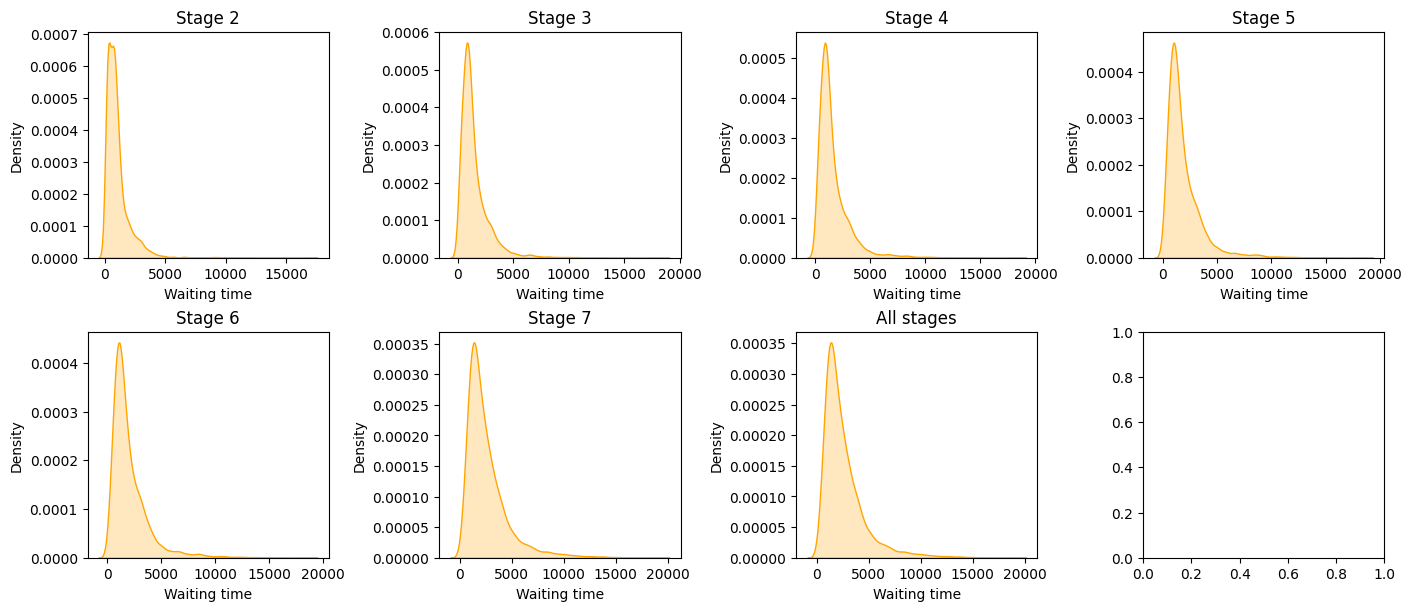

In [31]:
# Create a kernel density plot for each stage
fig, axes = plt.subplots(2, 4, layout='constrained', figsize=(14, 6))

#before redo point stage 2
sns.kdeplot(csectwo, fill=True, label='Stage 2', ax=axes[0,0], color='orange').set(title='Stage 2', xlabel='Waiting time')

#before redo point stage 3
sns.kdeplot(csecthree, fill=True, label='Stage 3', ax=axes[0,1], color='orange').set(title='Stage 3', xlabel='Waiting time')

#before redo point stage 4
sns.kdeplot(csecfour, fill=True, label='Stage 4', ax=axes[0,2], color='orange').set(title='Stage 4', xlabel='Waiting time')

#before redo point stage 5
sns.kdeplot(csecfive, fill=True, label='Stage 5', ax=axes[0,3], color='orange').set(title='Stage 5', xlabel='Waiting time')

#before redo point stage 6
sns.kdeplot(csecsix, fill=True, label='Stage 6', ax=axes[1,0], color='orange').set(title='Stage 6', xlabel='Waiting time')

#before redo point stage 7
sns.kdeplot(csecsev, fill=True, label='Stage 7', ax=axes[1,1], color='orange').set(title='Stage 7', xlabel='Waiting time')

#before redo point stages
sns.kdeplot(sectot, fill=True, label='All Stages', ax=axes[1,2], color='orange').set(title='All stages', xlabel='Waiting time')

plt.savefig('Results/kdpnotsplit.png')

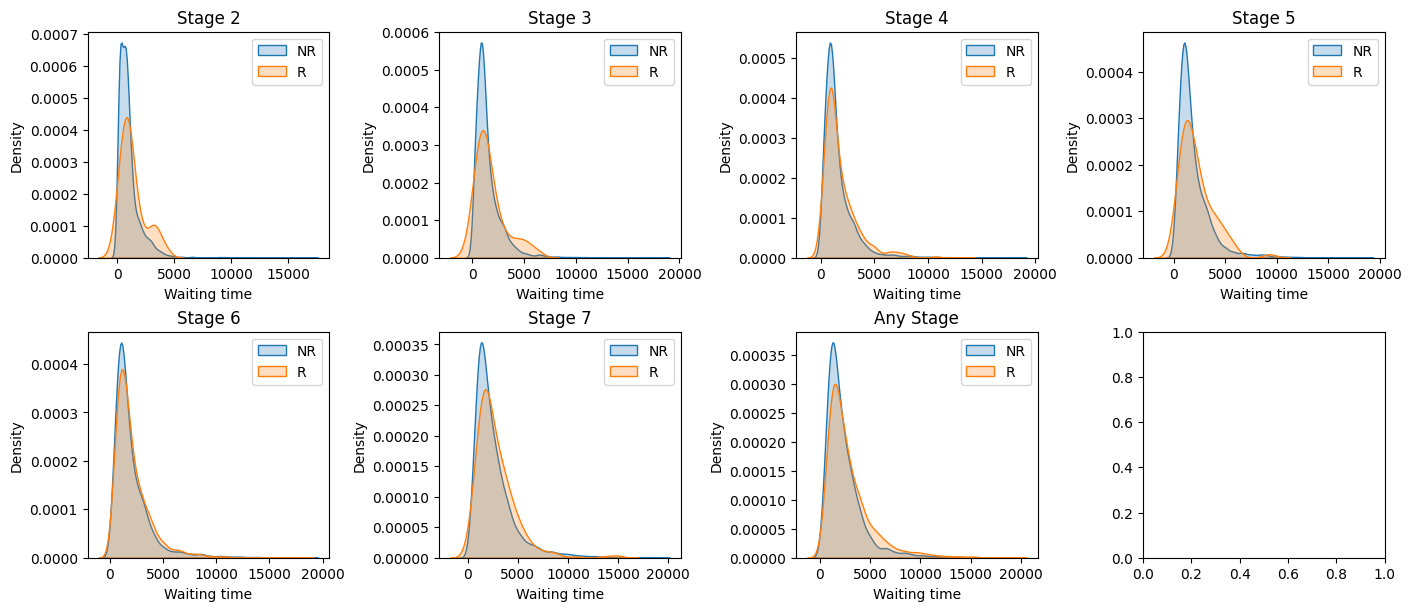

In [32]:
# Create a kernel density plot for each stage with split data
fig, axes = plt.subplots(2, 4, layout='constrained', figsize=(14, 6))

#before redo point stage 2
sns.kdeplot(csectwoF, fill=True, label='NR', ax=axes[0,0]).set(title='Stage 2', xlabel='Waiting time')
sns.kdeplot(csectwoT, fill=True, label='R', ax=axes[0,0])
axes[0,0].legend()

#before redo point stage 3
sns.kdeplot(csecthreeF, fill=True, label='NR', ax=axes[0,1]).set(title='Stage 3', xlabel='Waiting time')
sns.kdeplot(csecthreeT, fill=True, label='R', ax=axes[0,1])
axes[0,1].legend()

#before redo point stage 4
sns.kdeplot(csecfourF, fill=True, label='NR', ax=axes[0,2]).set(title='Stage 4', xlabel='Waiting time')
sns.kdeplot(csecfourT, fill=True, label='R', ax=axes[0,2])
axes[0,2].legend()


#before redo point stage 5
sns.kdeplot(csecfiveF, fill=True, label='NR', ax=axes[0,3]).set(title='Stage 5', xlabel='Waiting time')
sns.kdeplot(csecfiveT, fill=True, label='R', ax=axes[0,3])
axes[0,3].legend()

#before redo point stage 6
sns.kdeplot(csecsixF, fill=True, label='NR', ax=axes[1,0]).set(title='Stage 6', xlabel='Waiting time')
sns.kdeplot(csecsixT, fill=True, label='R', ax=axes[1,0])
axes[1,0].legend()


#before redo point stage 7
sns.kdeplot(csecsevF, fill=True, label='NR', ax=axes[1,1]).set(title='Stage 7', xlabel='Waiting time')
sns.kdeplot(csecsevT, fill=True, label='R', ax=axes[1,1])
axes[1,1].legend()


#before redo point stages
sns.kdeplot(sectotalF, fill=True, label='NR', ax=axes[1,2]).set(title='Any Stage', xlabel='Waiting time')
sns.kdeplot(sectotalT, fill=True, label='R', ax=axes[1,2])
axes[1,2].legend()

plt.savefig('Results/kdpsplit.png')

Investigating distributions: Q-Q plots

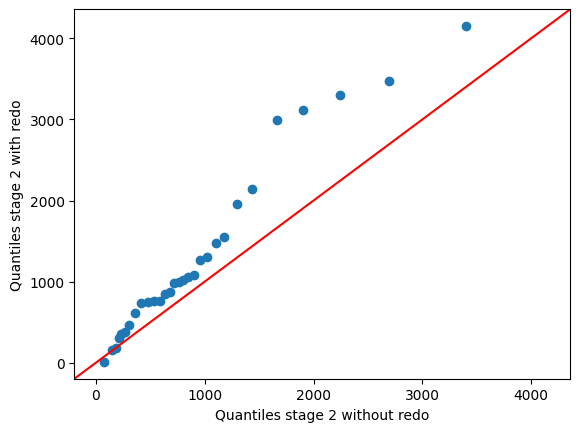

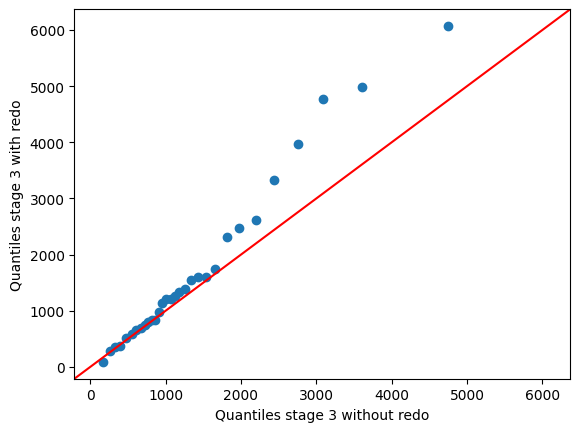

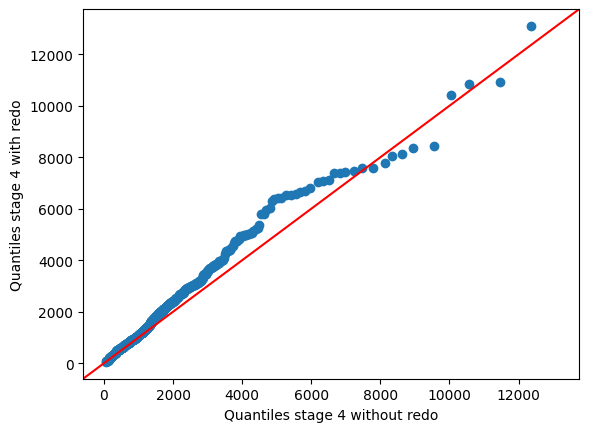

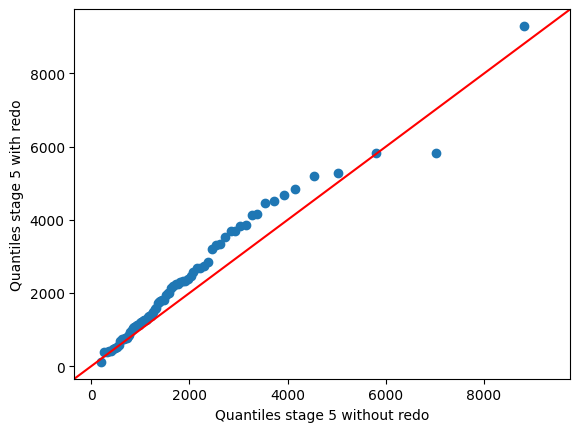

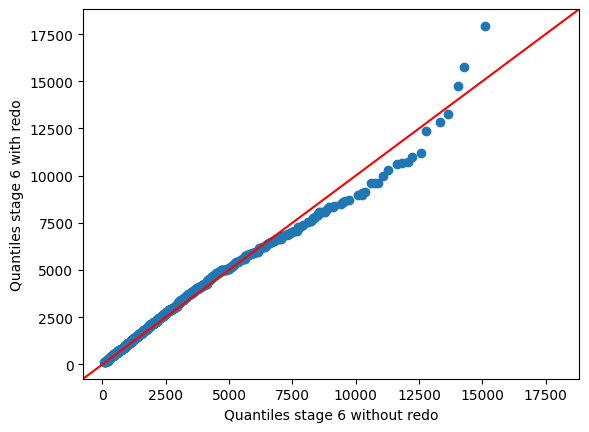

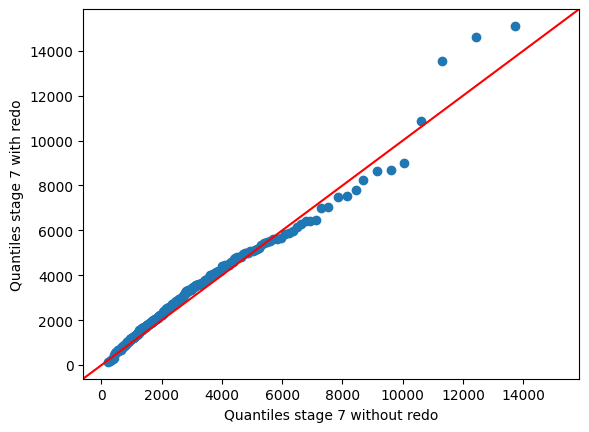

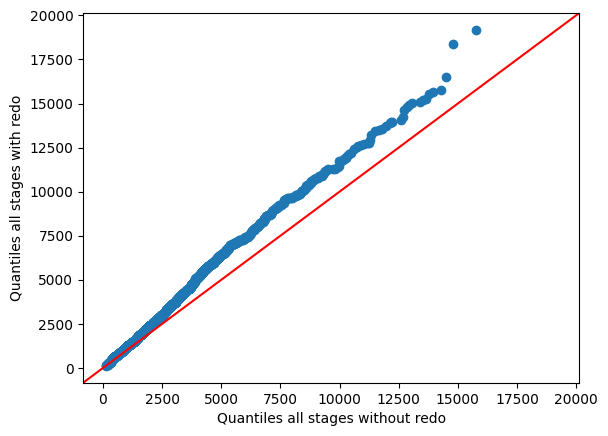

In [33]:
#compare to 45 degree line
#stage 2
statsmodels.graphics.gofplots.qqplot_2samples(csectwoF, csectwoT, xlabel='Quantiles stage 2 without redo', ylabel='Quantiles stage 2 with redo', line="45", ax=None);

#stage 3
statsmodels.graphics.gofplots.qqplot_2samples(csecthreeF, csecthreeT, xlabel='Quantiles stage 3 without redo', ylabel='Quantiles stage 3 with redo', line="45", ax=None);

#stage 4
statsmodels.graphics.gofplots.qqplot_2samples(csecfourF, csecfourT, xlabel='Quantiles stage 4 without redo', ylabel='Quantiles stage 4 with redo', line="45", ax=None);

#stage 5
statsmodels.graphics.gofplots.qqplot_2samples(csecfiveF, csecfiveT, xlabel='Quantiles stage 5 without redo', ylabel='Quantiles stage 5 with redo', line="45", ax=None);

#stage 6
statsmodels.graphics.gofplots.qqplot_2samples(csecsixF, csecsixT, xlabel='Quantiles stage 6 without redo', ylabel='Quantiles stage 6 with redo', line="45", ax=None);

#stage 7
statsmodels.graphics.gofplots.qqplot_2samples(csecsevF, csecsevT, xlabel='Quantiles stage 7 without redo', ylabel='Quantiles stage 7 with redo', line="45", ax=None);

#stage all
statsmodels.graphics.gofplots.qqplot_2samples(sectotalF, sectotalT, xlabel='Quantiles all stages without redo', ylabel='Quantiles all stages with redo', line="45", ax=None);

Investigating distributions: Outliers

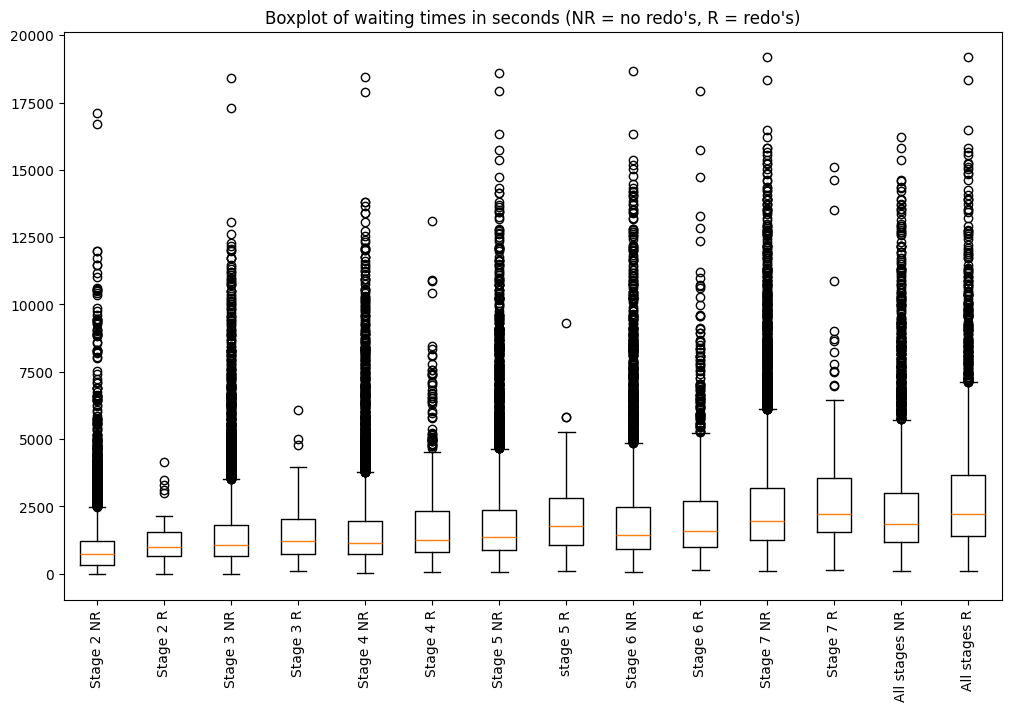

In [34]:
#plot outliers
fig, ax = plt.subplots(figsize =(10, 7), layout='constrained')
data = [csectwoF, csectwoT, csecthreeF, csecthreeT, csecfourF, csecfourT, csecfiveF, csecfiveT, csecsixF, csecsixT, csecsevF, csecsevT, sectotalF, sectotalT]
bp = ax.boxplot(data)
plt.title('Boxplot of waiting times in seconds (NR = no redo\'s, R = redo\'s)')
ax.set_xticklabels(['Stage 2 NR', 'Stage 2 R', 'Stage 3 NR', 'Stage 3 R', 'Stage 4 NR', 'Stage 4 R', 'Stage 5 NR', 'stage 5 R', 'Stage 6 NR', 'Stage 6 R' ,'Stage 7 NR','Stage 7 R', 'All stages NR', 'All stages R'])
plt.xticks(rotation='vertical')

# Display the plot and save it
plt.savefig("Results/boxplot.jpg")
plt.show()

Investigating distributions: Two-Sample Kolmogorov-Smirnov and Mann-Whitney U test

In [35]:
#delete tied values
ks_sectwoT = csectwoT.drop_duplicates()
ks_secthreeT = csecthreeT.drop_duplicates()
ks_secfourT = csecfourT.drop_duplicates()
ks_secfiveT = csecfiveT.drop_duplicates()
ks_secsixT = csecsixT.drop_duplicates()
ks_secsevT = csecsevT.drop_duplicates()
ks_sectotalT = sectotalT.drop_duplicates()
ks_sectwoF = csectwoF.drop_duplicates()
ks_secthreeF = csecthreeF.drop_duplicates()
ks_secfourF = csecfourF.drop_duplicates()
ks_secfiveF = csecfiveF.drop_duplicates()
ks_secsixF = csecsixF.drop_duplicates()
ks_secsevF = csecsevF.drop_duplicates()
ks_sectotalF = sectotalF.drop_duplicates()

In [36]:
# Perform the two-sample Kolmogorov-Smirnov test for each stage and the total
# except stage 1
ks_2 = ks_2samp(ks_sectwoT, ks_sectwoF)
ks_3 = ks_2samp(ks_secthreeT, ks_secthreeF)
ks_4 = ks_2samp(ks_secfourT, ks_secfourF)
ks_5 = ks_2samp(ks_secfiveT, ks_secfiveF)
ks_6 = ks_2samp(ks_secsixT, ks_secsixF)
ks_7 = ks_2samp(ks_secsevT, ks_secsevF)
ks_tot = ks_2samp(ks_sectotalT, ks_sectotalF)

# Display the results
print("Stage 2:", ks_2)
print("Stage 3:", ks_3)
print("Stage 4:", ks_4)
print("Stage 5:", ks_5)
print("Stage 6:", ks_6)
print("Stage 7:", ks_7)
print("All stages combined:", ks_tot)

Stage 2: KstestResult(statistic=0.23333333333333334, pvalue=0.06480509083529158, statistic_location=741.032, statistic_sign=-1)
Stage 3: KstestResult(statistic=0.11930016402405687, pvalue=0.727477880602053, statistic_location=1202.892, statistic_sign=-1)
Stage 4: KstestResult(statistic=0.07933702425786858, pvalue=0.0002954483608165793, statistic_location=1716.174, statistic_sign=-1)
Stage 5: KstestResult(statistic=0.13563936286178283, pvalue=0.1018867765207972, statistic_location=1734.343, statistic_sign=-1)
Stage 6: KstestResult(statistic=0.06058866062694058, pvalue=3.784298637527355e-05, statistic_location=1360.485, statistic_sign=-1)
Stage 7: KstestResult(statistic=0.1211720749186059, pvalue=0.0001618789172333386, statistic_location=1545.859, statistic_sign=-1)
All stages combined: KstestResult(statistic=0.10450024572490982, pvalue=8.165729571384725e-21, statistic_location=1856.94, statistic_sign=-1)


In [37]:
#perform Mann-Whitney U test for each stage and total, except stage one
mwu_2 = mannwhitneyu(ks_sectwoT, ks_sectwoF)
mwu_3 = mannwhitneyu(ks_secthreeT, ks_secthreeF)
mwu_4 = mannwhitneyu(ks_secfourT, ks_secfourF)
mwu_5 = mannwhitneyu(ks_secfiveT, ks_secfiveF)
mwu_6 = mannwhitneyu(ks_secsixT, ks_secsixF)
mwu_7 = mannwhitneyu(ks_secsevT, ks_secsevF)
mwu_tot = mannwhitneyu(ks_sectotalT, ks_sectotalF)

# Display the results
print("Stage 2:", mwu_2)
print("Stage 3:", mwu_3)
print("Stage 4:", mwu_4)
print("Stage 5:", mwu_5)
print("Stage 6:", mwu_6)
print("Stage 7:", mwu_7)
print("All stages combined:", mwu_tot)

Stage 2: MannwhitneyuResult(statistic=164656.0, pvalue=0.057298119595149785)
Stage 3: MannwhitneyuResult(statistic=152836.0, pvalue=0.45142303637437986)
Stage 4: MannwhitneyuResult(statistic=3489550.0, pvalue=2.1698812270355477e-05)
Stage 5: MannwhitneyuResult(statistic=408656.0, pvalue=0.03656784649949722)
Stage 6: MannwhitneyuResult(statistic=7179806.0, pvalue=6.000178891910579e-05)
Stage 7: MannwhitneyuResult(statistic=1615428.5, pvalue=0.0007725380955285161)
All stages combined: MannwhitneyuResult(statistic=11295921.0, pvalue=2.4888721100028415e-32)


Long wait: thresholds

In [38]:
#average waiting time, to compare to threshold if needed
print("The average waiting time up until the redo point of stage 2 is", np.average(csectwo), "seconds or,", np.average(csectwo)/60 , "minutes.")
print("The average waiting time up until the redo point of stage 3 is", np.average(csecthree), "seconds or,", np.average(csecthree)/60 , "minutes.")
print("The average waiting time up until the redo point of stage 4 is", np.average(csecfour), "seconds or,", np.average(csecfour)/60 , "minutes.")
print("The average waiting time up until the redo point of stage 5 is", np.average(csecfive), "seconds or,", np.average(csecfive)/60 , "minutes.")
print("The average waiting time up until the redo point of stage 6 is", np.average(csecsix), "seconds or,", np.average(csecsix)/60 , "minutes.")
print("The average waiting time up until the redo point of stage 7 is", np.average(csecsev), "seconds or,", np.average(csecsev)/60 , "minutes.")
print("The average waiting time for all stages is", np.average(sectot)/60 , "minutes.")

The average waiting time up until the redo point of stage 2 is 1016.9305145747227 seconds or, 16.94884190957871 minutes.
The average waiting time up until the redo point of stage 3 is 1477.8814482271046 seconds or, 24.631357470451743 minutes.
The average waiting time up until the redo point of stage 4 is 1619.858846204046 seconds or, 26.9976474367341 minutes.
The average waiting time up until the redo point of stage 5 is 1909.6829237546224 seconds or, 31.828048729243708 minutes.
The average waiting time up until the redo point of stage 6 is 2040.0578609963018 seconds or, 34.000964349938364 minutes.
The average waiting time up until the redo point of stage 7 is 2583.8846681531436 seconds or, 43.06474446921906 minutes.
The average waiting time for all stages is 43.1205935265753 minutes.


In [39]:
#set thresholds 3th quantile, everything above can be considered long wait
th2 = np.quantile(csectwo, 0.75)
th3 = np.quantile(csecthree, 0.75)
th4 = np.quantile(csecfour, 0.75)
th5 = np.quantile(csecfive, 0.75)
th6 = np.quantile(csecsix, 0.75)
th7 = np.quantile(csecsev, 0.75)
tht = np.quantile(sectot, 0.75)
print("Threshold stage 2:", th2, ", threshold stage 3:", th3, ", threshold stage 4:", th4, ", threshold stage 5:", th5, ", threshold stage 6:", th6, ", threshold stage 7:", th7, ", threshold all stages combined:", tht)

Threshold stage 2: 1204.9660000000001 , threshold stage 3: 1816.2959999999998 , threshold stage 4: 1978.69 , threshold stage 5: 2382.9005 , threshold stage 6: 2533.12675 , threshold stage 7: 3212.201 , threshold all stages combined: 3219.6715


Long wait: add boolean longwait column to wait, redos and nonredos

In [40]:
#stage 2
#if wait>th2 add yes, else no
productId = []
longwait = []

for row in wait.itertuples():
    if row.cafter_1.total_seconds() > th2:
        longwait.append(True)
        productId.append(row.product_id)
    else:
        longwait.append(False)
        productId.append(row.product_id)
        
#make dataframe
longwait2 = pd.DataFrame()
longwait2['product_id'] = productId
longwait2['long_wait_2'] = longwait

In [41]:
#stage 3
productId = []
longwait = []

for row in wait.itertuples():
    if row.cafter_12.total_seconds() > th3:
        longwait.append(True)
        productId.append(row.product_id)
    else:
        longwait.append(False)
        productId.append(row.product_id)
        
#make dataframe
longwait3 = pd.DataFrame()
longwait3['product_id'] = productId
longwait3['long_wait_3'] = longwait

In [42]:
#stage 4
productId = []
longwait = []

for row in wait.itertuples():
    if row.cafter_123.total_seconds() > th4:
        longwait.append(True)
        productId.append(row.product_id)
    else:
        longwait.append(False)
        productId.append(row.product_id)
        
#make dataframe
longwait4 = pd.DataFrame()
longwait4['product_id'] = productId
longwait4['long_wait_4'] = longwait

In [43]:
#stage 5
productId = []
longwait = []

for row in wait.itertuples():
    if row.cafter_1234.total_seconds() > th5:
        longwait.append(True)
        productId.append(row.product_id)
    else:
        longwait.append(False)
        productId.append(row.product_id)
        
#make dataframe
longwait5 = pd.DataFrame()
longwait5['product_id'] = productId
longwait5['long_wait_5'] = longwait

In [44]:
#stage 6
productId = []
longwait = []

for row in wait.itertuples():
    if row.cafter_12345.total_seconds() > th6:
        longwait.append(True)
        productId.append(row.product_id)
    else:
        longwait.append(False)
        productId.append(row.product_id)
        
#make dataframe
longwait6 = pd.DataFrame()
longwait6['product_id'] = productId
longwait6['long_wait_6'] = longwait

In [45]:
#stage 7
productId = []
longwait = []

for row in wait.itertuples():
    if row.cafter_123456.total_seconds() > th7:
        longwait.append(True)
        productId.append(row.product_id)
    else:
        longwait.append(False)
        productId.append(row.product_id)
        
#make dataframe
longwait7 = pd.DataFrame()
longwait7['product_id'] = productId
longwait7['long_wait_7'] = longwait

In [46]:
#stage total
productId = []
longwait = []

for row in wait.itertuples():
    if row.total.total_seconds() > tht:
        longwait.append(True)
        productId.append(row.product_id)
    else:
        longwait.append(False)
        productId.append(row.product_id)
        
#make dataframe
longwaitT = pd.DataFrame()
longwaitT['product_id'] = productId
longwaitT['long_wait_t'] = longwait

In [47]:
#merge longwait booleans to wait
wait = wait.merge(longwait2, on='product_id', how='inner')
wait = wait.merge(longwait3, on='product_id', how='inner')
wait = wait.merge(longwait4, on='product_id', how='inner')
wait = wait.merge(longwait5, on='product_id', how='inner')
wait = wait.merge(longwait6, on='product_id', how='inner')
wait = wait.merge(longwait7, on='product_id', how='inner')
wait = wait.merge(longwaitT, on='product_id', how='inner')

In [48]:
#run code that splits data again to add longwait columns to redos and nonredos
# select product ids with at least one redo
productRedo = []

for row in mainOrder.itertuples():
    if row.redo == True:
        productRedo.append(row.product_id)

#put in dataframe and drop duplicates
redos = pd.DataFrame()
redos['product_id'] = productRedo
redos = redos.drop_duplicates()      

#make dataframe containing the total wait times with this product Id
redos = redos.merge(wait, how='inner', on='product_id')
redos = redos.sort_values(by='product_id')

#products with no redos
#make set from product ids in redos and product ids in main and subtract them to get all product ids with no redos
setredo = set(productRedo)
setmain = set(mainOrder['product_id'])
setnonredo = setmain-setredo

#make dataframe and order it again
nonredo = list(setnonredo)
nonredos = pd.DataFrame()
nonredos['product_id'] = nonredo
nonredos = nonredos.drop_duplicates()
nonredos = nonredos.sort_values(by=['product_id'])

#add data to nonredos
nonredos = nonredos.merge(wait, how='inner', on='product_id')
nonredos = nonredos.sort_values(by='product_id')

Unconditional probabilities

In [49]:
#unconditional probability total proces
#take length no redo and devide by total
Pzero_all = len(nonredos)/len(wait) 
Patleast1_all = 1-Pzero_all

#PER STAGE
#stage 1
temp = cwaitone.loc[cwaitone['going_to_redo_1']==False]
Pzero_1 = len(temp)/len(cwaitone)
Pleast1_1 = 1 - Pzero_1

#stage 2
temp = cwaittwo.loc[cwaittwo['going_to_redo_2']==False]
Pzero_2 = len(temp)/len(cwaittwo)
Pleast1_2 = 1 - Pzero_2

#stage 3
temp = cwaitthree.loc[cwaitthree['going_to_redo_3']==False]
Pzero_3 = len(temp)/len(cwaitthree)
Pleast1_3 = 1 - Pzero_3

#stage 4
temp = cwaitfour.loc[cwaitfour['going_to_redo_4']==False]
Pzero_4 = len(temp)/len(cwaitfour)
Pleast1_4 = 1 - Pzero_4

#stage 5
temp = cwaitfive.loc[cwaitfive['going_to_redo_5']==False]
Pzero_5 = len(temp)/len(cwaitfive)
Pleast1_5 = 1 - Pzero_5

#stage 6
temp = cwaitsix.loc[cwaitsix['going_to_redo_6']==False]
Pzero_6 = len(temp)/len(cwaitsix)
Pleast1_6 = 1 - Pzero_6

#stage 7
temp = mainOrder.loc[mainOrder['stage']==7]
Pzero_7 = (len(temp['product_id'].unique())-len(cwaitsev))/len(temp['product_id'].unique())
#at least one redo
Pleast1_7 = 1 - Pzero_7

#display
print("The probability stage 1 has at least one redo is" , Pleast1_1)
print("The probability stage 2 has at least one redo is", Pleast1_2)
print("The probability stage 3 has at least one redo is", Pleast1_3)
print("The probability stage 4 has at least one redo is", Pleast1_4)
print("The probability stage 5 has at least one redo is", Pleast1_5)
print("The probability stage 6 has at least one redo is", Pleast1_6)
print("The probability stage 7 has at least one redo is", Pleast1_7)
print("The probability all stages have at least one redo is", Patleast1_all)

The probability stage 1 has at least one redo is 0.0
The probability stage 2 has at least one redo is 0.0032626427406199365
The probability stage 3 has at least one redo is 0.003371764194039617
The probability stage 4 has at least one redo is 0.08242714223575465
The probability stage 5 has at least one redo is 0.008590691605045664
The probability stage 6 has at least one redo is 0.2006088942046319
The probability stage 7 has at least one redo is 0.035982171975214694
The probability all stages have at least one redo is 0.3696976288884055


In [50]:
#number of redos per stage
print("The number of products with at least one redo for all stages is", len(redos['product_id'].unique()))
print("The number of products with at least one redo after stage 1 is", len(cwaitone.loc[cwaitone['going_to_redo_1']==True]))
print("The number of products with at least one redo after stage 2 is", len(wait.loc[wait['going_to_redo_2']==True]))
print("The number of products with at least one redo after stage 3 is", len(wait.loc[wait['going_to_redo_3']==True]))
print("The number of products with at least one redo after stage 4 is", len(wait.loc[wait['going_to_redo_4']==True]))
print("The number of products with at least one redo after stage 5 is", len(wait.loc[wait['going_to_redo_5']==True]))
print("The number of products with at least one redo after stage 6 is", len(wait.loc[wait['going_to_redo_6']==True]))
print("The number of products with at least one redo after stage 7 is", len(wait.loc[wait['going_to_redo_7']==True]))
print("The total number of products is", len(wait))

The number of products with at least one redo for all stages is 3399
The number of products with at least one redo after stage 1 is 0
The number of products with at least one redo after stage 2 is 30
The number of products with at least one redo after stage 3 is 31
The number of products with at least one redo after stage 4 is 758
The number of products with at least one redo after stage 5 is 79
The number of products with at least one redo after stage 6 is 1844
The number of products with at least one redo after stage 7 is 329
The total number of products is 9194


Conditional probabilities

In [51]:
#conditional probability theorem 
# P(redo | longwait) = P(redo intersect with longwait) / p(longwait)

#calculate probability for intersect
Pint2 = (wait['long_wait_2'] & wait['going_to_redo_2']).sum()/len(wait)
Pint3 = (wait['long_wait_3'] & wait['going_to_redo_3']).sum()/len(wait)
Pint4 = (wait['long_wait_4'] & wait['going_to_redo_4']).sum()/len(wait)
Pint5 = (wait['long_wait_5'] & wait['going_to_redo_5']).sum()/len(wait)
Pint6 = (wait['long_wait_6'] & wait['going_to_redo_6']).sum()/len(wait)
Pint7 = (wait['long_wait_7'] & wait['going_to_redo_7']).sum()/len(wait)
PintT = len(redos.loc[redos['long_wait_t']==True])/len(wait)

#calculate probability for longwait
Plw2 = wait['long_wait_2'].sum()/len(wait)
Plw3 = wait['long_wait_3'].sum()/len(wait)
Plw4 = wait['long_wait_4'].sum()/len(wait)
Plw5 = wait['long_wait_5'].sum()/len(wait)
Plw6 = wait['long_wait_6'].sum()/len(wait)
Plw7 = wait['long_wait_7'].sum()/len(wait)
PlwT = wait['long_wait_t'].sum()/len(wait)

#calculate conditional probability
Pcon2 = Pint2/Plw2
Pcon3 = Pint3/Plw3
Pcon4 = Pint4/Plw4
Pcon5 = Pint5/Plw5
Pcon6 = Pint6/Plw6
Pcon7 = Pint7/Plw7
PconT = PintT/PlwT

#print values
print("The probability that a product in stage 2 that has a long wait has a redo is", Pcon2)
print("The probability that a product in stage 3 that has a long wait has a redo is", Pcon3)
print("The probability that a product in stage 4 that has a long wait has a redo is", Pcon4)
print("The probability that a product in stage 5 that has a long wait has a redo is", Pcon5)
print("The probability that a product in stage 6 that has a long wait has a redo is", Pcon6)
print("The probability that a product in stage 7 that has a long wait has a redo is", Pcon7)
print("The probability/ that a product in all stages that has a long wait has a redo is", PconT)

The probability that a product in stage 2 that has a long wait has a redo is 0.004784688995215311
The probability that a product in stage 3 that has a long wait has a redo is 0.0034797738147020443
The probability that a product in stage 4 that has a long wait has a redo is 0.10482818616789909
The probability that a product in stage 5 that has a long wait has a redo is 0.010874293170943888
The probability that a product in stage 6 that has a long wait has a redo is 0.2218355806872553
The probability that a product in stage 7 that has a long wait has a redo is 0.04567203131796433
The probability/ that a product in all stages that has a long wait has a redo is 0.45672031317964334


In [52]:
#conditional probability theorem 
# P(redo | NOT longwait) = P(redo intersect with NOT longwait) / p(NOT longwait)

#calculate probability for intersect
Pint2 = ((~wait['long_wait_2']) & wait['going_to_redo_2']).sum()/len(wait)
Pint3 = ((~wait['long_wait_3']) & wait['going_to_redo_3']).sum()/len(wait)
Pint4 = ((~wait['long_wait_4']) & wait['going_to_redo_4']).sum()/len(wait)
Pint5 = ((~wait['long_wait_5']) & wait['going_to_redo_5']).sum()/len(wait)
Pint6 = ((~wait['long_wait_6']) & wait['going_to_redo_6']).sum()/len(wait)
Pint7 = ((~wait['long_wait_7']) & wait['going_to_redo_7']).sum()/len(wait)
PintT = len(redos.loc[redos['long_wait_t']==False])/len(wait)

#calculate probability for not longwait
Plw2 = (~wait['long_wait_2']).sum()/len(wait)
Plw3 = (~wait['long_wait_3']).sum()/len(wait)
Plw4 = (~wait['long_wait_4']).sum()/len(wait)
Plw5 = (~wait['long_wait_5']).sum()/len(wait)
Plw6 = (~wait['long_wait_6']).sum()/len(wait)
Plw7 = (~wait['long_wait_7']).sum()/len(wait)
PlwT = (~wait['long_wait_t']).sum()/len(wait)

#calculate conditional probability
NPcon2 = Pint2/Plw2
NPcon3 = Pint3/Plw3
NPcon4 = Pint4/Plw4
NPcon5 = Pint5/Plw5
NPcon6 = Pint6/Plw6
NPcon7 = Pint7/Plw7
NPconT = PintT/PlwT

#print values
print("The probability that a product in stage 2 that does not have a long wait has a redo is", NPcon2)
print("The probability that a product in stage 3 that does not have a long wait has a redo is", NPcon3)
print("The probability that a product in stage 4 that does not have a long wait has a redo is", NPcon4)
print("The probability that a product in stage 5 that does not have a long wait has a redo is", NPcon5)
print("The probability that a product in stage 6 that does not have a long wait has a redo is", NPcon6)
print("The probability that a product in stage 7 that does not have a long wait has a redo is", NPcon7)
print("The probability that a product in all stages that does not have a long wait has a redo is", NPconT)

The probability that a product in stage 2 that does not have a long wait has a redo is 0.002755620014503263
The probability that a product in stage 3 that does not have a long wait has a redo is 0.0033357505438723714
The probability that a product in stage 4 that does not have a long wait has a redo is 0.07498187092095722
The probability that a product in stage 5 that does not have a long wait has a redo is 0.007831762146482959
The probability that a product in stage 6 that does not have a long wait has a redo is 0.19347353154459754
The probability that a product in stage 7 that does not have a long wait has a redo is 0.03248730964467005
The probability that a product in all stages that does not have a long wait has a redo is 0.3406816533720087


In [53]:
#probability formulas to present difference
#longwait is 0 for no long wait and 1 for a long wait
print(round(Pleast1_2,4), "+", round(Pcon2 - Pleast1_2, 4), "* longwait")
print(round(Pleast1_3,4), "+", round(Pcon3 - Pleast1_3, 4), "* longwait")
print(round(Pleast1_4,4), "+", round(Pcon4 - Pleast1_4, 4), "* longwait")
print(round(Pleast1_5,4), "+", round(Pcon5 - Pleast1_5, 4), "* longwait")
print(round(Pleast1_6,4), "+", round(Pcon6 - Pleast1_6, 4), "* longwait")
print(round(Pleast1_7,4), "+", round(Pcon7 - Pleast1_7, 4), "* longwait")
print(round(Patleast1_all,4), "+", round(PconT - Patleast1_all, 4), "* longwait")

0.0033 + 0.0015 * longwait
0.0034 + 0.0001 * longwait
0.0824 + 0.0224 * longwait
0.0086 + 0.0023 * longwait
0.2006 + 0.0212 * longwait
0.036 + 0.0097 * longwait
0.3697 + 0.087 * longwait


Average Treatment Effect

In [54]:
#calculate new wait times for cumulative wait times after redo point
waiti = wait
waiti['cafter_234567'] = waiti['cafter_2'] + waiti['cafter_3'] + waiti['cafter_4'] + waiti['cafter_5'] + waiti['cafter_67']
waiti['cafter_34567'] = waiti['cafter_3'] + waiti['cafter_4'] + waiti['cafter_5'] + waiti['cafter_67']
waiti['cafter_4567'] = waiti['cafter_4'] + waiti['cafter_5'] + waiti['cafter_67']
waiti['cafter_567'] = waiti['cafter_5'] + waiti['cafter_67']

In [55]:
#calculate ATE
ATET = redos['total'].mean() - nonredos['total'].mean()
ATE2 = waiti.loc[waiti['going_to_redo_2']==True]['cafter_234567'].mean() - waiti.loc[waiti['going_to_redo_2']==False]['cafter_234567'].mean()
ATE3 = waiti.loc[waiti['going_to_redo_3']==True]['cafter_34567'].mean() - waiti.loc[waiti['going_to_redo_3']==False]['cafter_34567'].mean()
ATE4 = waiti.loc[waiti['going_to_redo_4']==True]['cafter_4567'].mean() - waiti.loc[waiti['going_to_redo_4']==False]['cafter_4567'].mean()
ATE5 = waiti.loc[waiti['going_to_redo_5']==True]['cafter_567'].mean() - waiti.loc[waiti['going_to_redo_5']==False]['cafter_567'].mean()
ATE6 = waiti.loc[waiti['going_to_redo_6']==True]['cafter_67'].mean() - waiti.loc[waiti['going_to_redo_6']==False]['cafter_67'].mean()
ATE7 = waiti.loc[waiti['going_to_redo_7']==True]['cafter_67'].mean() - waiti.loc[waiti['going_to_redo_7']==False]['cafter_67'].mean()

#print values
print("If all products had a redo after stage 2, the expected wait time after would change with", ATE2)
print("If all products had a redo after stage 3, the expected wait time after would change with", ATE3)
print("If all products had a redo after stage 4, the expected wait time after would change with", ATE4)
print("If all products had a redo after stage 5, the expected wait time after would change with", ATE5)
print("If all products had a redo after stage 6, the expected wait time after would change with", ATE6)
print("If all products had a redo after stage 7, the expected wait time after would change with", ATE7)
print("If all products had a redo somewhere in the process, the expected total wait time would change with", ATET)

If all products had a redo after stage 2, the expected wait time after would change with 0 days 00:27:47.889455616
If all products had a redo after stage 3, the expected wait time after would change with 0 days 01:12:21.978156661
If all products had a redo after stage 4, the expected wait time after would change with 0 days 00:05:04.679078879
If all products had a redo after stage 5, the expected wait time after would change with 0 days 00:06:01.852500986
If all products had a redo after stage 6, the expected wait time after would change with 0 days 00:03:26.840828150
If all products had a redo after stage 7, the expected wait time after would change with 0 days 00:03:15.674869610
If all products had a redo somewhere in the process, the expected total wait time would change with 0 days 00:08:41.623417632


**Tests on non-cumulative waiting times**
-

Convert wait time timedeltas to seconds and split data into redos and nonredos

In [56]:
#waiting times after each stage in seconds
secone = waitone['after_1'].dt.total_seconds()
sectwo = waittwo['after_2'].dt.total_seconds()
secthree = waitthree['after_3'].dt.total_seconds()
secfour = waitfour['after_4'].dt.total_seconds()
secfive = waitfive['after_5'].dt.total_seconds()
secsix = waitsix['after_6'].dt.total_seconds()
secsev = waitsev['after_7'].dt.total_seconds()
secsevsix = wait['cafter_67'].dt.total_seconds()
sectot = wait['total'].dt.total_seconds()

In [57]:
#split data for tests 
seconeT = waitone.loc[waitone['going_to_redo_1']==True]['after_1'].dt.total_seconds()
seconeF = waitone.loc[waitone['going_to_redo_1']==False]['after_1'].dt.total_seconds()
sectwoT = waittwo.loc[waittwo['going_to_redo_2']==True]['after_2'].dt.total_seconds()
sectwoF = waittwo.loc[waittwo['going_to_redo_2']==False]['after_2'].dt.total_seconds()
secthreeT = waitthree.loc[waitthree['going_to_redo_3']==True]['after_3'].dt.total_seconds()
secthreeF = waitthree.loc[waitthree['going_to_redo_3']==False]['after_3'].dt.total_seconds()
secfourT = waitfour.loc[waitfour['going_to_redo_4']==True]['after_4'].dt.total_seconds()
secfourF = waitfour.loc[waitfour['going_to_redo_4']==False]['after_4'].dt.total_seconds()
secfiveT = waitfive.loc[waitfive['going_to_redo_5']==True]['after_5'].dt.total_seconds()
secfiveF = waitfive.loc[waitfive['going_to_redo_5']==False]['after_5'].dt.total_seconds()
secsixT = waitsix.loc[waitsix['going_to_redo_6']==True]['after_6'].dt.total_seconds()
secsixF = waitsix.loc[waitsix['going_to_redo_6']==False]['after_6'].dt.total_seconds()
secsevT = waitsev.loc[waitsev['going_to_redo_7']==True]['after_7'].dt.total_seconds()
secsevF = waitsev.loc[waitsev['going_to_redo_7']==False]['after_7'].dt.total_seconds()

Investigating distributions: Kernal density plots

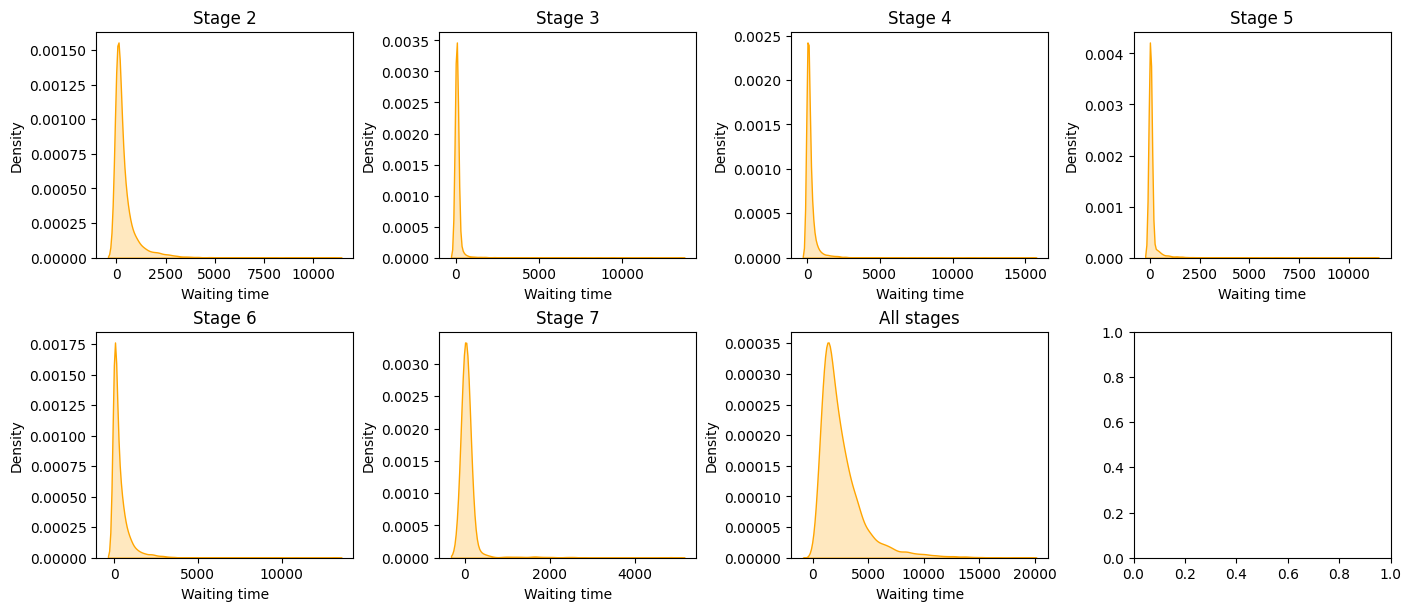

In [58]:
# Create a kernel density plot for each stage
fig, axes = plt.subplots(2, 4, layout='constrained', figsize=(14, 6))

#before redo point stage 2
sns.kdeplot(sectwo, fill=True, label='Stage 2', ax=axes[0,0], color='orange').set(title='Stage 2', xlabel='Waiting time')

#before redo point stage 3
sns.kdeplot(secthree, fill=True, label='Stage 3', ax=axes[0,1], color='orange').set(title='Stage 3', xlabel='Waiting time')

#before redo point stage 4
sns.kdeplot(secfour, fill=True, label='Stage 4', ax=axes[0,2], color='orange').set(title='Stage 4', xlabel='Waiting time')

#before redo point stage 5
sns.kdeplot(secfive, fill=True, label='Stage 5', ax=axes[0,3], color='orange').set(title='Stage 5', xlabel='Waiting time')

#before redo point stage 6
sns.kdeplot(secsix, fill=True, label='Stage 6', ax=axes[1,0], color='orange').set(title='Stage 6', xlabel='Waiting time')

#before redo point stage 7
sns.kdeplot(secsev, fill=True, label='Stage 7', ax=axes[1,1], color='orange').set(title='Stage 7', xlabel='Waiting time')

#before redo point stages
sns.kdeplot(sectot, fill=True, label='All Stages', ax=axes[1,2], color='orange').set(title='All stages', xlabel='Waiting time')

plt.savefig('Results/kdpnotsplitNC.png')

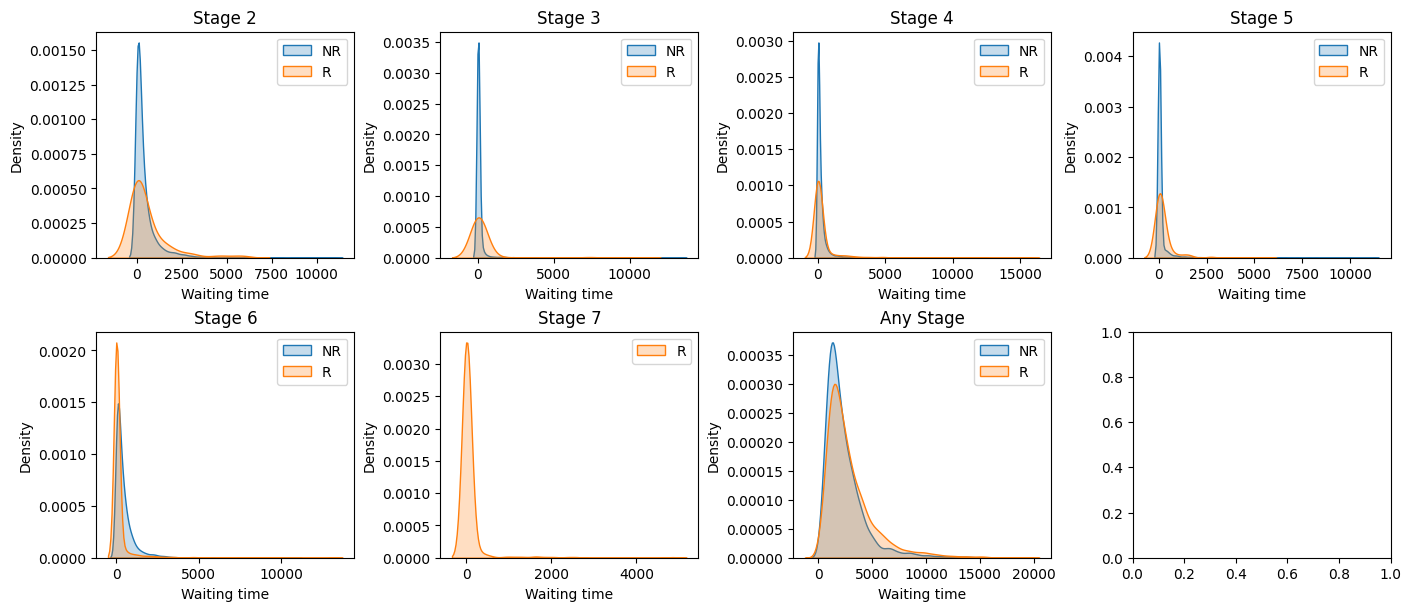

In [59]:
#kdes
# Create a kernel density plot for each stage with split data
fig, axes = plt.subplots(2, 4, layout='constrained', figsize=(14, 6))

#before redo point stage 2
sns.kdeplot(sectwoF, fill=True, label='NR', ax=axes[0,0]).set(title='Stage 2', xlabel='Waiting time')
sns.kdeplot(sectwoT, fill=True, label='R', ax=axes[0,0])
axes[0,0].legend()

#before redo point stage 3
sns.kdeplot(secthreeF, fill=True, label='NR', ax=axes[0,1]).set(title='Stage 3', xlabel='Waiting time')
sns.kdeplot(secthreeT, fill=True, label='R', ax=axes[0,1])
axes[0,1].legend()

#before redo point stage 4
sns.kdeplot(secfourF, fill=True, label='NR', ax=axes[0,2]).set(title='Stage 4', xlabel='Waiting time')
sns.kdeplot(secfourT, fill=True, label='R', ax=axes[0,2])
axes[0,2].legend()


#before redo point stage 5
sns.kdeplot(secfiveF, fill=True, label='NR', ax=axes[0,3]).set(title='Stage 5', xlabel='Waiting time')
sns.kdeplot(secfiveT, fill=True, label='R', ax=axes[0,3])
axes[0,3].legend()

#before redo point stage 6
sns.kdeplot(secsixF, fill=True, label='NR', ax=axes[1,0]).set(title='Stage 6', xlabel='Waiting time')
sns.kdeplot(secsixT, fill=True, label='R', ax=axes[1,0])
axes[1,0].legend()


#before redo point stage 7
sns.kdeplot(secsevF, fill=True, label='NR', ax=axes[1,1]).set(title='Stage 7', xlabel='Waiting time')
sns.kdeplot(secsevT, fill=True, label='R', ax=axes[1,1])
axes[1,1].legend()


#before redo point stages
sns.kdeplot(sectotalF, fill=True, label='NR', ax=axes[1,2]).set(title='Any Stage', xlabel='Waiting time')
sns.kdeplot(sectotalT, fill=True, label='R', ax=axes[1,2])
axes[1,2].legend()

plt.savefig('Results/kdpsplitNC.png')

Investigating distributions: Q-Q plots

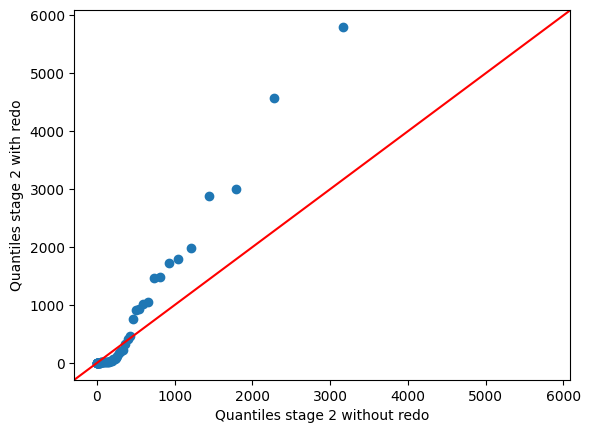

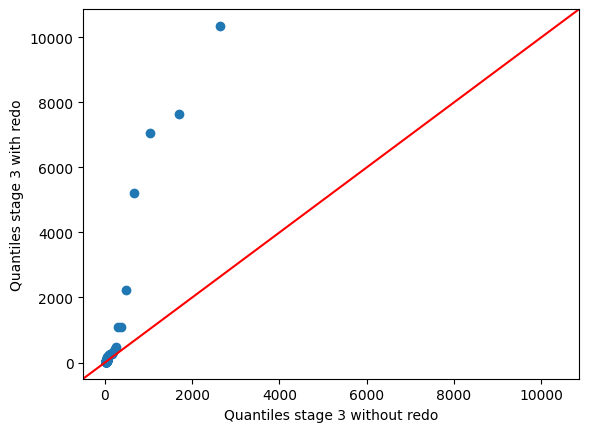

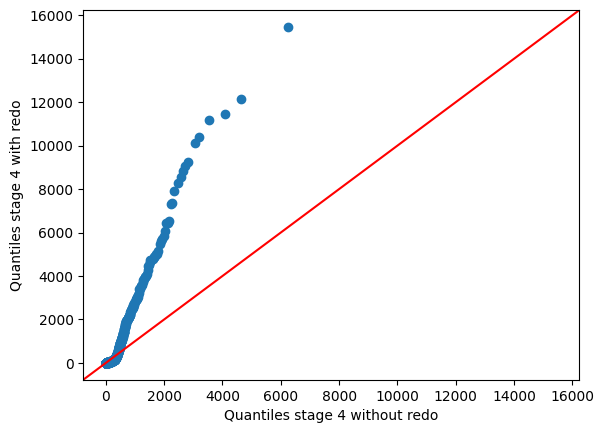

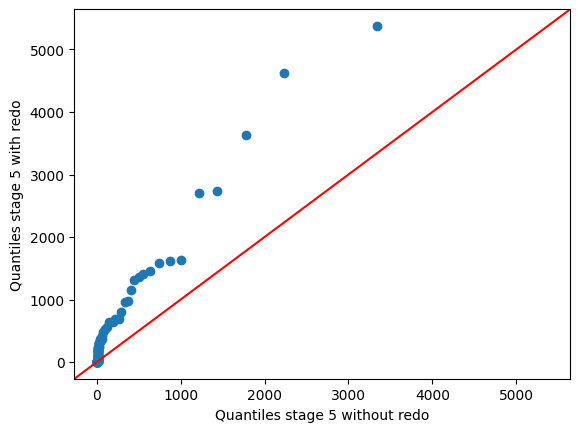

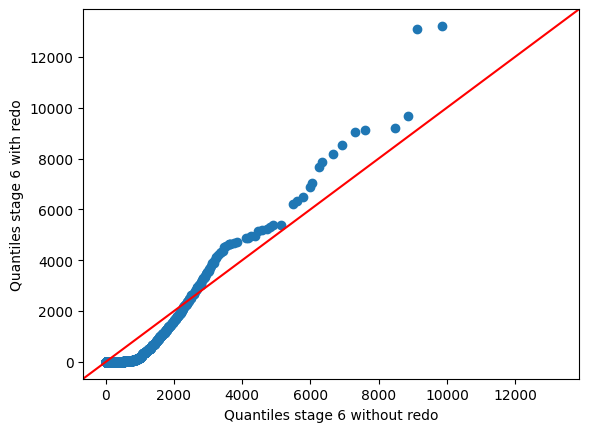

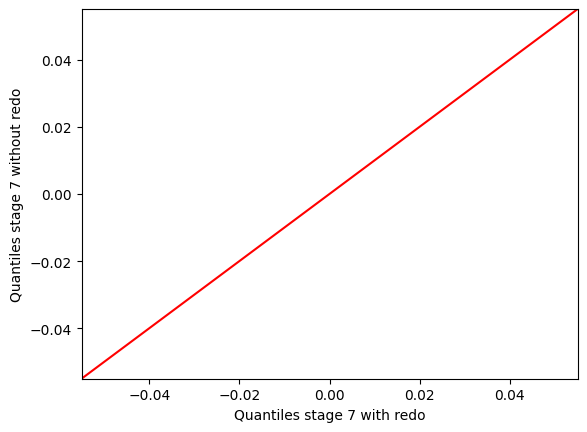

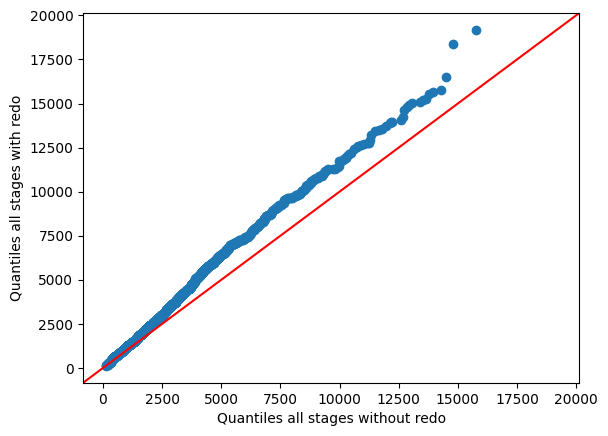

In [60]:
#compare to 45 degree line
#stage 2
statsmodels.graphics.gofplots.qqplot_2samples(sectwoF, sectwoT, xlabel='Quantiles stage 2 without redo', ylabel='Quantiles stage 2 with redo', line="45", ax=None);

#stage 3
statsmodels.graphics.gofplots.qqplot_2samples(secthreeF, secthreeT, xlabel='Quantiles stage 3 without redo', ylabel='Quantiles stage 3 with redo', line="45", ax=None);

#stage 4
statsmodels.graphics.gofplots.qqplot_2samples(secfourF, secfourT, xlabel='Quantiles stage 4 without redo', ylabel='Quantiles stage 4 with redo', line="45", ax=None);

#stage 5
statsmodels.graphics.gofplots.qqplot_2samples(secfiveF, secfiveT, xlabel='Quantiles stage 5 without redo', ylabel='Quantiles stage 5 with redo', line="45", ax=None);

#stage 6
statsmodels.graphics.gofplots.qqplot_2samples(secsixF, secsixT, xlabel='Quantiles stage 6 without redo', ylabel='Quantiles stage 6 with redo', line="45", ax=None);

#stage 7
statsmodels.graphics.gofplots.qqplot_2samples(secsevF, secsevT, xlabel='Quantiles stage 7 without redo', ylabel='Quantiles stage 7 with redo', line="45", ax=None);

#stage all
statsmodels.graphics.gofplots.qqplot_2samples(sectotalF, sectotalT, xlabel='Quantiles all stages without redo', ylabel='Quantiles all stages with redo', line="45", ax=None);

Investigating distributions: outliers

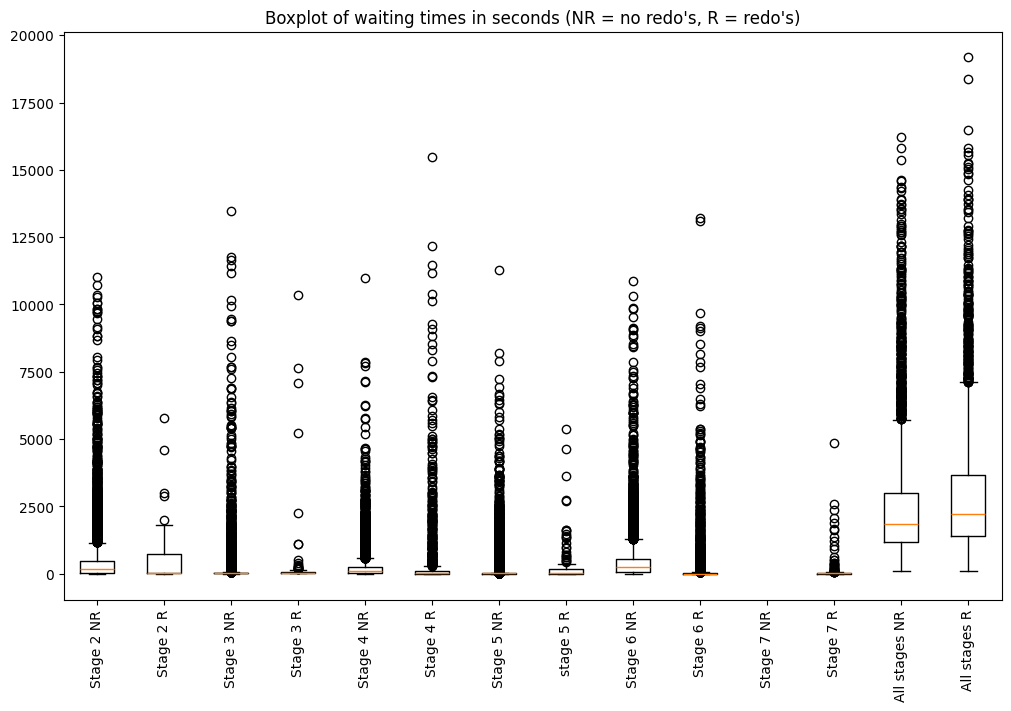

In [61]:
#plot outliers
fig, ax = plt.subplots(figsize =(10, 7), layout='constrained')
data = [sectwoF, sectwoT, secthreeF, secthreeT, secfourF, secfourT, secfiveF, secfiveT, secsixF, secsixT, secsevF, secsevT, sectotalF, sectotalT]
bp = ax.boxplot(data)
plt.title('Boxplot of waiting times in seconds (NR = no redo\'s, R = redo\'s)')
ax.set_xticklabels(['Stage 2 NR', 'Stage 2 R', 'Stage 3 NR', 'Stage 3 R', 'Stage 4 NR', 'Stage 4 R', 'Stage 5 NR', 'stage 5 R', 'Stage 6 NR', 'Stage 6 R' ,'Stage 7 NR','Stage 7 R', 'All stages NR', 'All stages R'])
plt.xticks(rotation='vertical')

# Display the plot and save it
plt.savefig("Results/boxplotNC.jpg")
plt.show()

Investigating distributions: Two-Sample Kolmogorov-Smirnov and Mann-Whitney U tests

In [62]:
#delete tied values
ks_sectwoT = sectwoT.drop_duplicates()
ks_secthreeT = secthreeT.drop_duplicates()
ks_secfourT = secfourT.drop_duplicates()
ks_secfiveT = secfiveT.drop_duplicates()
ks_secsixT = secsixT.drop_duplicates()
ks_secsevT = secsevT.drop_duplicates()
ks_sectotalT = sectotalT.drop_duplicates()
ks_sectwoF = sectwoF.drop_duplicates()
ks_secthreeF = secthreeF.drop_duplicates()
ks_secfourF = secfourF.drop_duplicates()
ks_secfiveF = secfiveF.drop_duplicates()
ks_secsixF = secsixF.drop_duplicates()
ks_secsevF = secsevF.drop_duplicates()
ks_sectotalF = sectotalF.drop_duplicates()

In [63]:
# Perform the two-sample Kolmogorov-Smirnov test for each stage and the total
ks_2 = ks_2samp(ks_sectwoT, ks_sectwoF)
ks_3 = ks_2samp(ks_secthreeT, ks_secthreeF)
ks_4 = ks_2samp(ks_secfourT, ks_secfourF)
ks_5 = ks_2samp(ks_secfiveT, ks_secfiveF)
ks_6 = ks_2samp(ks_secsixT, ks_secsixF)
ks_tot = ks_2samp(ks_sectotalT, ks_sectotalF)

# Display the results
print("Stage 2:", ks_2)
print("Stage 3:", ks_3)
print("Stage 4:", ks_4)
print("Stage 5:", ks_5)
print("Stage 6:", ks_6)
print("All stages combined:", ks_tot)

Stage 2: KstestResult(statistic=0.308254168069441, pvalue=6.0675201725160906e-05, statistic_location=19.777, statistic_sign=1)
Stage 3: KstestResult(statistic=0.13561374366147927, pvalue=0.031085281537560735, statistic_location=54.192, statistic_sign=-1)
Stage 4: KstestResult(statistic=0.33405029961181903, pvalue=1.496516604145156e-107, statistic_location=10.077, statistic_sign=1)
Stage 5: KstestResult(statistic=0.3186008804592717, pvalue=1.1441076543402226e-15, statistic_location=16.66, statistic_sign=-1)
Stage 6: KstestResult(statistic=0.5694083647968151, pvalue=4.195e-321, statistic_location=37.622, statistic_sign=1)
All stages combined: KstestResult(statistic=0.10450024572490982, pvalue=8.165729571384725e-21, statistic_location=1856.94, statistic_sign=-1)


In [64]:
#perform test for each stage and total
mwu_2 = mannwhitneyu(ks_sectwoT, ks_sectwoF)
mwu_3 = mannwhitneyu(ks_secthreeT, ks_secthreeF)
mwu_4 = mannwhitneyu(ks_secfourT, ks_secfourF)
mwu_5 = mannwhitneyu(ks_secfiveT, ks_secfiveF)
mwu_6 = mannwhitneyu(ks_secsixT, ks_secsixF)
mwu_tot = mannwhitneyu(ks_sectotalT, ks_sectotalF)

# Display the results
print("Stage 2:", mwu_2)
print("Stage 3:", mwu_3)
print("Stage 4:", mwu_4)
print("Stage 5:", mwu_5)
print("Stage 6:", mwu_6)
print("All stages combined:", mwu_tot)

Stage 2: MannwhitneyuResult(statistic=193103.5, pvalue=0.01556802396316008)
Stage 3: MannwhitneyuResult(statistic=493713.5, pvalue=0.14983096234537555)
Stage 4: MannwhitneyuResult(statistic=3884716.5, pvalue=2.854845530712243e-59)
Stage 5: MannwhitneyuResult(statistic=782679.5, pvalue=2.5017542371503303e-07)
Stage 6: MannwhitneyuResult(statistic=3880210.5, pvalue=0.0)
All stages combined: MannwhitneyuResult(statistic=11295921.0, pvalue=2.4888721100028415e-32)


Long wait: thresholds

In [65]:
#redefine wait times summed per product per stage to prevent merging issues later
secone = cwaitone['cafter_1'].dt.total_seconds()
sectwo = cwaittwo['cafter_2'].dt.total_seconds()
secthree = cwaitthree['cafter_3'].dt.total_seconds()
secfour = cwaitfour['cafter_4'].dt.total_seconds()
secfive = cwaitfive['cafter_5'].dt.total_seconds()
secsix = cwaitsix['cafter_6'].dt.total_seconds()
secsevsix = wait['cafter_67'].dt.total_seconds()
sectot = wait['total'].dt.total_seconds()

In [66]:
#thresholds
th2n = np.quantile(sectwo, 0.75)
th3n = np.quantile(secthree, 0.75)
th4n = np.quantile(secfour, 0.75)
th5n = np.quantile(secfive, 0.75)
th6n = np.quantile(secsix, 0.75)
th7n = np.quantile(secsev, 0.75)
thtn = np.quantile(sectot, 0.75)
print("Threshold stage 2:", th2n, ", threshold stage 3:", th3n, ", threshold stage 4:", th4n, ", threshold stage 5:", th5n, ", threshold stage 6:", th6n, ", threshold stage 7:", th7n, ", threshold all stages combined:", thtn)

Threshold stage 2: 487.581 , threshold stage 3: 43.918499999999995 , threshold stage 4: 263.82574999999997 , threshold stage 5: 15.39225 , threshold stage 6: 608.643 , threshold stage 7: 25.0615 , threshold all stages combined: 3219.6715


Long wait: add boolean longwait column to wait, redos and nonredos

In [67]:
waitn = wait

In [68]:
#stage 2
#if wait>th2 add yes, else no
productId = []
longwait = []

for row in waitn.itertuples():
    if row.cafter_1.total_seconds() > th2n:
        longwait.append(True)
        productId.append(row.product_id)
    else:
        longwait.append(False)
        productId.append(row.product_id)
        
#make dataframe
longwait2 = pd.DataFrame()
longwait2['product_id'] = productId
longwait2['long_wait_2n'] = longwait

In [69]:
#stage 3
productId = []
longwait = []

for row in waitn.itertuples():
    if row.cafter_2.total_seconds() > th3n:
        longwait.append(True)
        productId.append(row.product_id)
    else:
        longwait.append(False)
        productId.append(row.product_id)
        
#make dataframe
longwait3 = pd.DataFrame()
longwait3['product_id'] = productId
longwait3['long_wait_3n'] = longwait

In [70]:
#stage 4
productId = []
longwait = []

for row in waitn.itertuples():
    if row.cafter_3.total_seconds() > th4n:
        longwait.append(True)
        productId.append(row.product_id)
    else:
        longwait.append(False)
        productId.append(row.product_id)
        
#make dataframe
longwait4 = pd.DataFrame()
longwait4['product_id'] = productId
longwait4['long_wait_4n'] = longwait

In [71]:
#stage 5
productId = []
longwait = []

for row in waitn.itertuples():
    if row.cafter_4.total_seconds() > th5n:
        longwait.append(True)
        productId.append(row.product_id)
    else:
        longwait.append(False)
        productId.append(row.product_id)
        
#make dataframe
longwait5 = pd.DataFrame()
longwait5['product_id'] = productId
longwait5['long_wait_5n'] = longwait

In [72]:
#stage 6
productId = []
longwait = []

for row in waitn.itertuples():
    if row.cafter_5.total_seconds() > th6n:
        longwait.append(True)
        productId.append(row.product_id)
    else:
        longwait.append(False)
        productId.append(row.product_id)
        
#make dataframe
longwait6 = pd.DataFrame()
longwait6['product_id'] = productId
longwait6['long_wait_6n'] = longwait

In [73]:
#stage 7
productId = []
longwait = []

for row in waitn.itertuples():
    if row.cafter_6.total_seconds() > th7n:
        longwait.append(True)
        productId.append(row.product_id)
    else:
        longwait.append(False)
        productId.append(row.product_id)
        
#make dataframe
longwait7 = pd.DataFrame()
longwait7['product_id'] = productId
longwait7['long_wait_7n'] = longwait

In [74]:
#stage total
productId = []
longwait = []

for row in waitn.itertuples():
    if row.total.total_seconds() > thtn:
        longwait.append(True)
        productId.append(row.product_id)
    else:
        longwait.append(False)
        productId.append(row.product_id)
        
#make dataframe
longwaitT = pd.DataFrame()
longwaitT['product_id'] = productId
longwaitT['long_wait_tn'] = longwait

In [75]:
#merge longwait booleans to wait
waitn = waitn.merge(longwait2, on='product_id', how='inner')
waitn = waitn.merge(longwait3, on='product_id', how='inner')
waitn = waitn.merge(longwait4, on='product_id', how='inner')
waitn = waitn.merge(longwait5, on='product_id', how='inner')
waitn = waitn.merge(longwait6, on='product_id', how='inner')
waitn = waitn.merge(longwait7, on='product_id', how='inner')
waitn = waitn.merge(longwaitT, on='product_id', how='inner')

In [76]:
#run code that splits wait again to add longwait columns
# select product ids with at least one redo
productRedo = []

for row in mainOrder.itertuples():
    if row.redo == True:
        productRedo.append(row.product_id)

#put in dataframe and drop duplicates
redosn = pd.DataFrame()
redosn['product_id'] = productRedo
redosn = redosn.drop_duplicates()      

#make dataframe containing the total wait times with this product Id
redosn = waitn.merge(redosn, how='inner', on='product_id')
redosn = redosn.sort_values(by='product_id')

#products with no redos
#make set from product ids in redos and product ids in main and subtract them to get all product ids with no redos
setredo = set(productRedo)
setmain = set(mainOrder['product_id'])
setnonredo = setmain-setredo

#make dataframe and order it again
nonredo = list(setnonredo)
nonredosn = pd.DataFrame()
nonredosn['product_id'] = nonredo
nonredosn = nonredos.drop_duplicates()
nonredosn = nonredos.sort_values(by=['product_id'])

#add data to nonredos
nonredosn = waitn.merge(nonredosn, how='inner', on='product_id')
nonredosn = nonredosn.sort_values(by='product_id')

Conditional Probabilities

In [77]:
#conditional probability theorem 
# P(redo | longwait) = P(redo intersect with longwait) / p(longwait)

#calculate probability for intersect
Pint2n = (waitn['long_wait_2n'] & waitn['going_to_redo_2']).sum()/len(waitn)
Pint3n = (waitn['long_wait_3n'] & waitn['going_to_redo_3']).sum()/len(waitn)
Pint4n = (waitn['long_wait_4n'] & waitn['going_to_redo_4']).sum()/len(waitn)
Pint5n = (waitn['long_wait_5n'] & waitn['going_to_redo_5']).sum()/len(waitn)
Pint6n = (waitn['long_wait_6n'] & waitn['going_to_redo_6']).sum()/len(waitn)
Pint7n = (waitn['long_wait_7n'] & waitn['going_to_redo_7']).sum()/len(waitn)
PintTn = len(redosn.loc[redosn['long_wait_tn']==True])/len(waitn)

#calculate probability for longwait
Plw2n = waitn['long_wait_2n'].sum()/len(waitn)
Plw3n = waitn['long_wait_3n'].sum()/len(waitn)
Plw4n = waitn['long_wait_4n'].sum()/len(waitn)
Plw5n = waitn['long_wait_5n'].sum()/len(waitn)
Plw6n = waitn['long_wait_6n'].sum()/len(waitn)
Plw7n = waitn['long_wait_7n'].sum()/len(waitn)
PlwTn = waitn['long_wait_tn'].sum()/len(waitn)

#calculate conditional probability
Pcon2n = Pint2n/Plw2n
Pcon3n = Pint3n/Plw3n
Pcon4n = Pint4n/Plw4n
Pcon5n = Pint5n/Plw5n
Pcon6n = Pint6n/Plw6n
Pcon7n = Pint7n/Plw7n
PconTn = PintTn/PlwTn

#print values
print("The probability that a product in stage 2 that has a long wait has a redo is", Pcon2n)
print("The probability that a product in stage 3 that has a long wait has a redo is", Pcon3n)
print("The probability that a product in stage 4 that has a long wait has a redo is", Pcon4n)
print("The probability that a product in stage 5 that has a long wait has a redo is", Pcon5n)
print("The probability that a product in stage 6 that has a long wait has a redo is", Pcon6n)
print("The probability that a product in stage 7 that has a long wait has a redo is", Pcon7n)
print("The probability that a product in all stages that has a long wait has a redo is", PconTn)

The probability that a product in stage 2 that has a long wait has a redo is 0.003721080731273257
The probability that a product in stage 3 that has a long wait has a redo is 0.0037464408811628954
The probability that a product in stage 4 that has a long wait has a redo is 0.1331316187594554
The probability that a product in stage 5 that has a long wait has a redo is 0.009350717766363755
The probability that a product in stage 6 that has a long wait has a redo is 0.16342412451361868
The probability that a product in stage 7 that has a long wait has a redo is 0.03715247475377135
The probability that a product in all stages that has a long wait has a redo is 0.45672031317964334


In [78]:
#conditional probability theorem 
# P(redo | NOT longwait) = P(redo intersect with NOT longwait) / p(NOT longwait)

#calculate probability for intersect
Pint2n = ((~waitn['long_wait_2n']) & waitn['going_to_redo_2']).sum()/len(waitn)
Pint3n = ((~waitn['long_wait_3n']) & waitn['going_to_redo_3']).sum()/len(waitn)
Pint4n = ((~waitn['long_wait_4n']) & waitn['going_to_redo_4']).sum()/len(waitn)
Pint5n = ((~waitn['long_wait_5n']) & waitn['going_to_redo_5']).sum()/len(waitn)
Pint6n = ((~waitn['long_wait_6n']) & waitn['going_to_redo_6']).sum()/len(waitn)
Pint7n = ((~waitn['long_wait_7n']) & waitn['going_to_redo_7']).sum()/len(waitn)
PintTn = len(redosn.loc[redosn['long_wait_tn']==False])/len(waitn)

#calculate probability for not longwait
Plw2n = (~waitn['long_wait_2n']).sum()/len(waitn)
Plw3n = (~waitn['long_wait_3n']).sum()/len(waitn)
Plw4n = (~waitn['long_wait_4n']).sum()/len(waitn)
Plw5n = (~waitn['long_wait_5n']).sum()/len(waitn)
Plw6n = (~waitn['long_wait_6n']).sum()/len(waitn)
Plw7n = (~waitn['long_wait_7n']).sum()/len(waitn)
PlwTn = (~waitn['long_wait_tn']).sum()/len(waitn)

#calculate conditional probability
NPcon2n = Pint2n/Plw2n
NPcon3n = Pint3n/Plw3n
NPcon4n = Pint4n/Plw4n
NPcon5n = Pint5n/Plw5n
NPcon6n = Pint6n/Plw6n
NPcon7n = Pint7n/Plw7n
NPconTn = PintTn/PlwTn

#print values
print("The probability that a product in stage 2 that has a not long wait has a redo is", NPcon2n)
print("The probability that a product in stage 3 that has a not long wait has a redo is", NPcon3n)
print("The probability that a product in stage 4 that has a not long wait has a redo is", NPcon4n)
print("The probability that a product in stage 5 that has a not long wait has a redo is", NPcon5n)
print("The probability that a product in stage 6 that has a not long wait has a redo is", NPcon6n)
print("The probability that a product in stage 7 that has a not long wait has a redo is", NPcon7n)
print("The probability/ that a product in all stages that has a not long wait has a redo is", NPconTn)

The probability that a product in stage 2 that has a not long wait has a redo is 0.002323265847992035
The probability that a product in stage 3 that has a not long wait has a redo is 0.002380007933359778
The probability that a product in stage 4 that has a not long wait has a redo is 0.07851869213641159
The probability that a product in stage 5 that has a not long wait has a redo is 0.004996876951905059
The probability that a product in stage 6 that has a not long wait has a redo is 0.20276497695852536
The probability that a product in stage 7 that has a not long wait has a redo is 0.026427962489343565
The probability/ that a product in all stages that has a not long wait has a redo is 0.3406816533720087


In [79]:
#probability formulas to present 
#longwait is 0 for no long wait and 1 for a long wait
print(round(Pleast1_2,4), "+", round(Pcon2n - Pleast1_2, 4), "* longwait")
print(round(Pleast1_3,4), "+", round(Pcon3n - Pleast1_3, 4), "* longwait")
print(round(Pleast1_4,4), "+", round(Pcon4n - Pleast1_4, 4), "* longwait")
print(round(Pleast1_5,4), "+", round(Pcon5n - Pleast1_5, 4), "* longwait")
print(round(Pleast1_6,4), "+", round(Pcon6n - Pleast1_6, 4), "* longwait")
print(round(Pleast1_7,4), "+", round(Pcon7n - Pleast1_7, 4), "* longwait")
print(round(Patleast1_all,4), "+", round(PconTn - Patleast1_all, 4), "* longwait")

0.0033 + 0.0005 * longwait
0.0034 + 0.0004 * longwait
0.0824 + 0.0507 * longwait
0.0086 + 0.0008 * longwait
0.2006 + -0.0372 * longwait
0.036 + 0.0012 * longwait
0.3697 + 0.087 * longwait


Average Treatment Effect

In [80]:
# calculate ATE
ATET = redos['total'].mean() - nonredos['total'].mean()
ATE2 = wait.loc[wait['going_to_redo_2']==True]['cafter_2'].mean() - wait.loc[wait['going_to_redo_2']==False]['cafter_2'].mean()
ATE3 = wait.loc[wait['going_to_redo_3']==True]['cafter_3'].mean() - wait.loc[wait['going_to_redo_3']==False]['cafter_3'].mean()
ATE4 = wait.loc[wait['going_to_redo_4']==True]['cafter_4'].mean() - wait.loc[wait['going_to_redo_4']==False]['cafter_4'].mean()
ATE5 = wait.loc[wait['going_to_redo_5']==True]['cafter_5'].mean() - wait.loc[wait['going_to_redo_5']==False]['cafter_5'].mean()
ATE6 = wait.loc[wait['going_to_redo_6']==True]['cafter_6'].mean() - wait.loc[wait['going_to_redo_6']==False]['cafter_6'].mean()
ATE7 = wait.loc[wait['going_to_redo_7']==True]['cafter_67'].mean() - wait.loc[wait['going_to_redo_7']==False]['cafter_67'].mean()

#print values
print("If all products had a redo after stage 2, the expected wait time after would change with", ATE2)
print("If all products had a redo after stage 3, the expected wait time after would change with", ATE3)
print("If all products had a redo after stage 4, the expected wait time after would change with", ATE4)
print("If all products had a redo after stage 5, the expected wait time after would change with", ATE5)
print("If all products had a redo after stage 6, the expected wait time after would change with", ATE6)
print("If all products had a redo after stage 7, the expected wait time after would change with", ATE7)
print("If all products had a redo somewhere in the process, the expected total wait time would change with", ATET)

If all products had a redo after stage 2, the expected wait time after would change with 0 days 00:12:11.896509574
If all products had a redo after stage 3, the expected wait time after would change with 0 days 00:12:13.914317071
If all products had a redo after stage 4, the expected wait time after would change with 0 days 00:04:56.979755322
If all products had a redo after stage 5, the expected wait time after would change with 0 days 00:04:04.012782640
If all products had a redo after stage 6, the expected wait time after would change with 0 days 00:03:30.067524842
If all products had a redo after stage 7, the expected wait time after would change with 0 days 00:03:15.674869610
If all products had a redo somewhere in the process, the expected total wait time would change with 0 days 00:08:41.623417632


# Investigating distributions: normal distribution
### Found in appendix in report
Due to the Central Limit Theorem, the hypothesis was that the waiting time can be displayed as Normal/Gaussian distribution\
Because the decision was made later to not use z-tests, these tests were only done for cumulative data (except for the first frequency histogram)

Frequency histogram

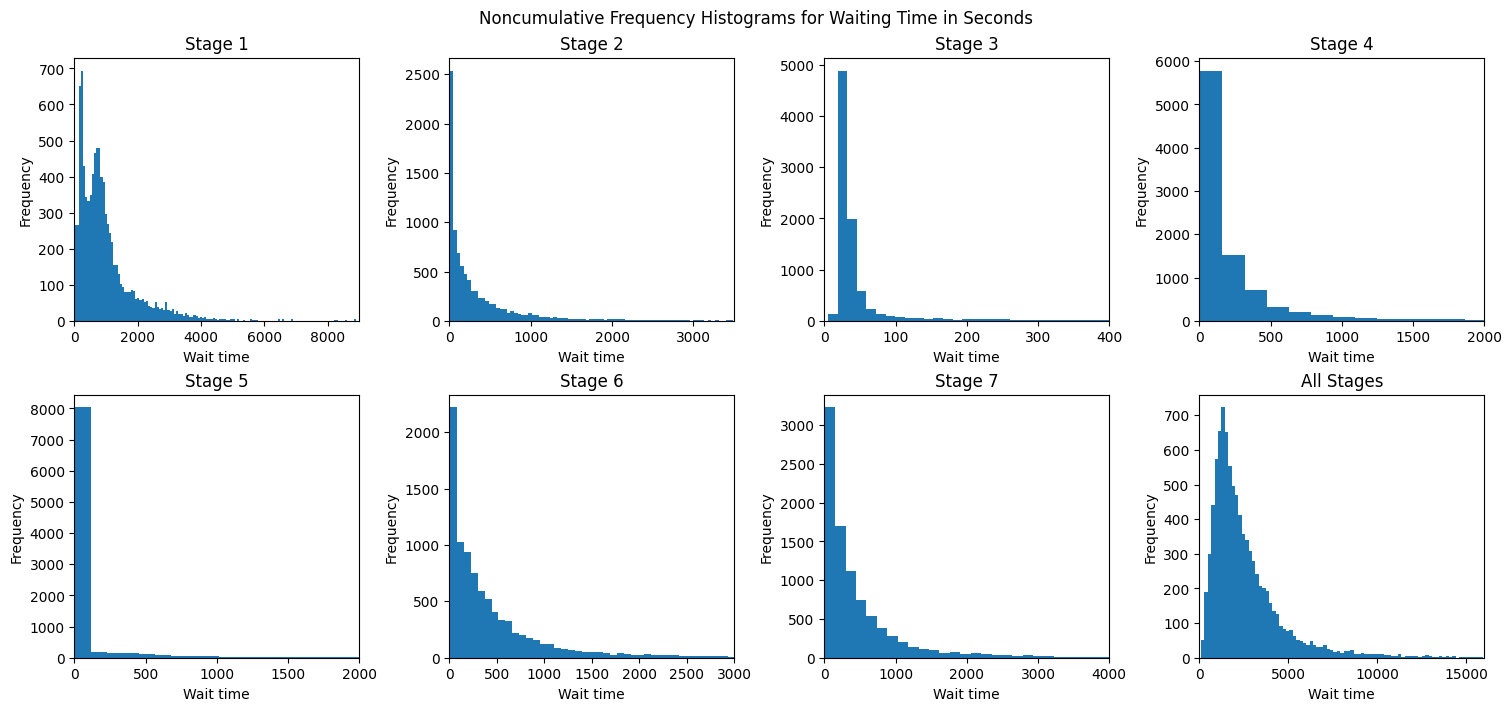

In [81]:
#Frequency histograms for non-cumulative waiting times
#make subplots, maybe add figure size
fig, ax = plt.subplots(2, 4, layout='constrained', figsize=(15, 7))
plt.suptitle('Noncumulative Frequency Histograms for Waiting Time in Seconds')

#stage 1
ax[0, 0].hist(secone, bins=250)
ax[0, 0].set_title("Stage 1")
ax[0, 0].set_xlim([0, 9000])
ax[0, 0].set_xlabel("Wait time")
ax[0, 0].set_ylabel("Frequency")

#stage 2
ax[0, 1].hist(sectwo, bins=250)
ax[0, 1].set_title("Stage 2")
ax[0, 1].set_xlim([0, 3500])
ax[0, 1].set_xlabel("Wait time")
ax[0, 1].set_ylabel("Frequency")

#stage 3
ax[0, 2].hist(secthree, bins=1000)
ax[0, 2].set_title("Stage 3")
ax[0, 2].set_xlim([0, 400])
ax[0, 2].set_xlabel("Wait time")
ax[0, 2].set_ylabel("Frequency")

#stage 4
ax[0, 3].hist(secfour, bins=100)
ax[0, 3].set_title("Stage 4")
ax[0, 3].set_xlim([0, 2000])
ax[0, 3].set_xlabel("Wait time")
ax[0, 3].set_ylabel("Frequency")

#stage 5
ax[1, 0].hist(secfive, bins=100)
ax[1, 0].set_title("Stage 5")
ax[1, 0].set_xlim([0, 2000])
ax[1, 0].set_xlabel("Wait time")
ax[1, 0].set_ylabel("Frequency")

#stage 6
ax[1, 1].hist(secsix, bins=200)
ax[1, 1].set_title("Stage 6")
ax[1, 1].set_xlim([0, 3000])
ax[1, 1].set_xlabel("Wait time")
ax[1, 1].set_ylabel("Frequency")

#stage 7
ax[1, 2].hist(secsevsix, bins=100)
ax[1, 2].set_title("Stage 7")
ax[1, 2].set_xlim([0, 4000])
ax[1, 2].set_xlabel("Wait time")
ax[1, 2].set_ylabel("Frequency")

#stage all
ax[1, 3].hist(sectot, bins=100)
ax[1, 3].set_title("All Stages")
ax[1, 3].set_xlim([0, 16000])
ax[1, 3].set_xlabel("Wait time")
ax[1, 3].set_ylabel("Frequency")

#save figure and show plots
plt.savefig('Results/freqnotsplit.png')
plt.show()

Frequency histograms where redos are split from the nonredos

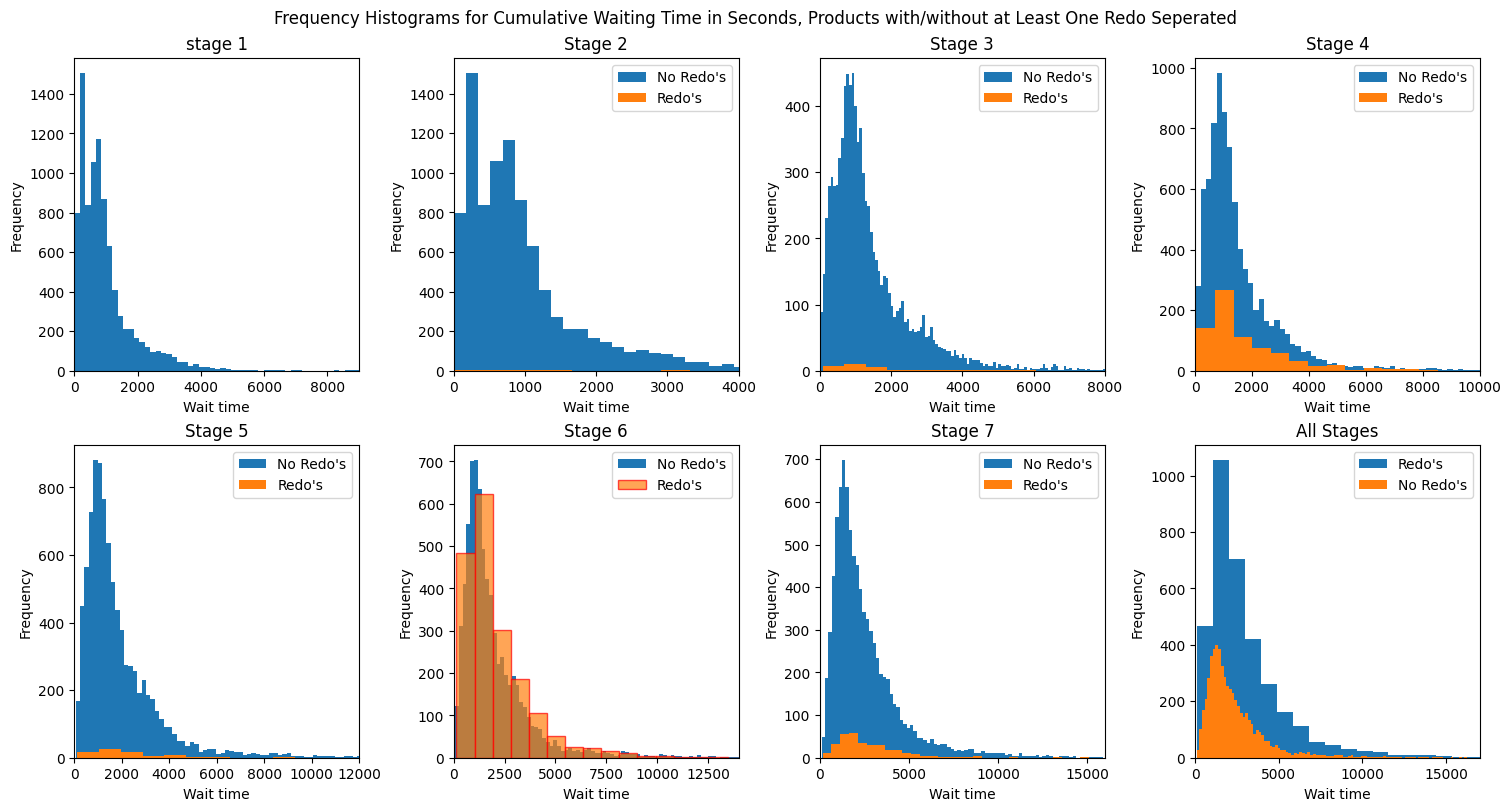

In [82]:
#Frequency histograms
#make subplots, maybe add figure size
fig, ax = plt.subplots(2, 4, layout='constrained', figsize=(15, 8))
plt.suptitle('Frequency Histograms for Cumulative Waiting Time in Seconds, Products with/without at Least One Redo Seperated')

#stage 1
ax[0, 0].hist(secone, bins=100)
ax[0, 0].set_title("stage 1")
ax[0, 0].set_xlim([0, 9000])
ax[0, 0].set_xlabel("Wait time")
ax[0, 0].set_ylabel("Frequency")

#stage 2
ax[0, 1].hist(csectwoF, label='No Redo\'s', bins=100)
ax[0, 1].hist(csectwoT, label='Redo\'s')
ax[0, 1].set_title("Stage 2")
ax[0, 1].set_xlim([0, 4000]) #8000 when everything needs to be visible
ax[0, 1].legend()
ax[0, 1].set_xlabel("Wait time")
ax[0, 1].set_ylabel("Frequency")

#stage 3
ax[0, 2].hist(csecthreeF, label='No Redo\'s', bins=250)
ax[0, 2].hist(csecthreeT, label='Redo\'s')
ax[0, 2].set_title("Stage 3")
ax[0, 2].set_xlim([0, 8000]) #1300 when everything needs to be visible
ax[0, 2].legend()
ax[0, 2].set_xlabel("Wait time")
ax[0, 2].set_ylabel("Frequency")

#stage 4
ax[0, 3].hist(csecfourF, label='No Redo\'s', bins=100)
ax[0, 3].hist(csecfourT, label='Redo\'s', bins=20)
ax[0, 3].set_title("Stage 4")
ax[0, 3].set_xlim([0, 10000])
ax[0, 3].legend()
ax[0, 3].set_xlabel("Wait time")
ax[0, 3].set_ylabel("Frequency")

#stage 5
ax[1, 0].hist(csecfiveF, label='No Redo\'s', bins=100)
ax[1, 0].hist(csecfiveT, label='Redo\'s')
ax[1, 0].set_title("Stage 5")
ax[1, 0].set_xlim([0, 12000])
ax[1, 0].legend()
ax[1, 0].set_xlabel("Wait time")
ax[1, 0].set_ylabel("Frequency")

#stage 6
ax[1, 1].hist(csecsixF, label='No Redo\'s', alpha=1, bins=100)
ax[1, 1].hist(csecsixT, label='Redo\'s', alpha=0.7, edgecolor='red', bins=20)
ax[1, 1].set_title("Stage 6")
ax[1, 1].set_xlim([0, 14000])
ax[1, 1].legend()
ax[1, 1].set_xlabel("Wait time")
ax[1, 1].set_ylabel("Frequency")

#stage 7
ax[1, 2].hist(csecsevF, label='No Redo\'s', bins=100)
ax[1, 2].hist(csecsevT, label='Redo\'s', bins=30)
ax[1, 2].set_title("Stage 7")
ax[1, 2].set_xlim([0, 16000])
ax[1, 2].legend()
ax[1, 2].set_xlabel("Wait time")
ax[1, 2].set_ylabel("Frequency")

#stage all
ax[1, 3].hist(sectotalT, label='Redo\'s', bins=20)
ax[1, 3].hist(sectotalF, label='No Redo\'s', bins=100)
ax[1, 3].set_title("All Stages")
ax[1, 3].set_xlim([0, 17000])
ax[1, 3].legend()
ax[1, 3].set_xlabel("Wait time")
ax[1, 3].set_ylabel("Frequency")

plt.savefig('Results/freqhistsplit.png')
plt.show()

To check if the waiting times are normally distributed, use normaltest, anderson and chapiro. 

In [83]:
#cumulative and log transformed waiting times
logcsectwo = np.log1p(csectwo)
logcsecthree = np.log1p(csecthree)
logcsecfour = np.log1p(csecfour)
logcsecfive = np.log1p(csecfive)
logcsecsix = np.log1p(csecsix)
logcsecsev = np.log1p(csecsev)
logsectot = np.log1p(sectot)

In [84]:
#stage 2
#normality test
print(stats.normaltest(logcsectwo))
#normal test not robust to outliers, try shapiro wilk test (sensitive to sample size)
print(shapiro(logcsectwo))
#anderson-darling test
print(anderson(logcsectwo))

NormaltestResult(statistic=1118.1134257588333, pvalue=1.602339450881828e-243)
ShapiroResult(statistic=0.9679853916168213, pvalue=5.807821615240637e-41)
AndersonResult(statistic=57.74166820293431, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=6.476629778377721, scale=1.0268485301235655)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


c:\Users\20183207\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [85]:
#stage 3
#normality test
print(stats.normaltest(logcsecthree))
#normal test not robust to outliers, try shapiro wilk test (sensitive to sample size)
print(shapiro(logcsecthree))
#anderson-darling test
print(anderson(logcsecthree))

NormaltestResult(statistic=611.962261140817, pvalue=1.3004193609570745e-133)
ShapiroResult(statistic=0.98115473985672, pvalue=3.84018355645096e-33)
AndersonResult(statistic=39.72394810075457, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=6.949088129463512, scale=0.876060062225845)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [86]:
#stage 4
#normality test
print(stats.normaltest(logcsecfour))
#normal test not robust to outliers, try shapiro wilk test (sensitive to sample size)
print(shapiro(logcsecfour))
#anderson-darling test
print(anderson(logcsecfour))

NormaltestResult(statistic=177.48408843653758, pvalue=2.8828356444015832e-39)
ShapiroResult(statistic=0.991922914981842, pvalue=1.961746241079578e-22)
AndersonResult(statistic=21.58913810384911, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=7.048448547270443, scale=0.844609161613505)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [87]:
#stage 5
#normality test
print(stats.normaltest(logcsecfive))
#normal test not robust to outliers, try shapiro wilk test (sensitive to sample size)
print(shapiro(logcsecfive))
#anderson-darling test
print(anderson(logcsecfive))

NormaltestResult(statistic=76.59031035344775, pvalue=2.3368208725859664e-17)
ShapiroResult(statistic=0.9961240887641907, pvalue=6.196928193979772e-15)
AndersonResult(statistic=8.88616734543939, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=7.2462507932976985, scale=0.7933229049662275)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [88]:
#stage 6
#normality test
print(stats.normaltest(logcsecsix))
#normal test not robust to outliers, try shapiro wilk test (sensitive to sample size)
print(shapiro(logcsecsix))
#anderson-darling test
print(anderson(logcsecsix))

NormaltestResult(statistic=49.832426529759644, pvalue=1.5101708015733123e-11)
ShapiroResult(statistic=0.9966155290603638, pvalue=9.92503266530019e-14)
AndersonResult(statistic=8.24048316216431, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=7.320351178856389, scale=0.7771481461077274)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [89]:
#stage 7
#normality test
print(stats.normaltest(logcsecsev))
#normal test not robust to outliers, try shapiro wilk test (sensitive to sample size)
print(shapiro(logcsecsev))
#anderson-darling test
print(anderson(logcsecsev))

NormaltestResult(statistic=28.345190553766987, pvalue=6.997132162760692e-07)
ShapiroResult(statistic=0.9978507161140442, pvalue=4.205335246698638e-10)
AndersonResult(statistic=3.742321629075377, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=7.600518362616319, scale=0.7193437721617689)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [90]:
#stage all
#normality test
print(stats.normaltest(logsectot))
#normal test not robust to outliers, try shapiro wilk test (sensitive to sample size)
print(shapiro(logsectot))
#anderson-darling test
print(anderson(logsectot))

NormaltestResult(statistic=27.334054178910666, pvalue=1.1600736198692322e-06)
ShapiroResult(statistic=0.997885525226593, pvalue=5.525865320876733e-10)
AndersonResult(statistic=3.6722670180297428, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=7.601837069248123, scale=0.7193901734655669)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


Q-Q plots to compare distributions to normal distribution

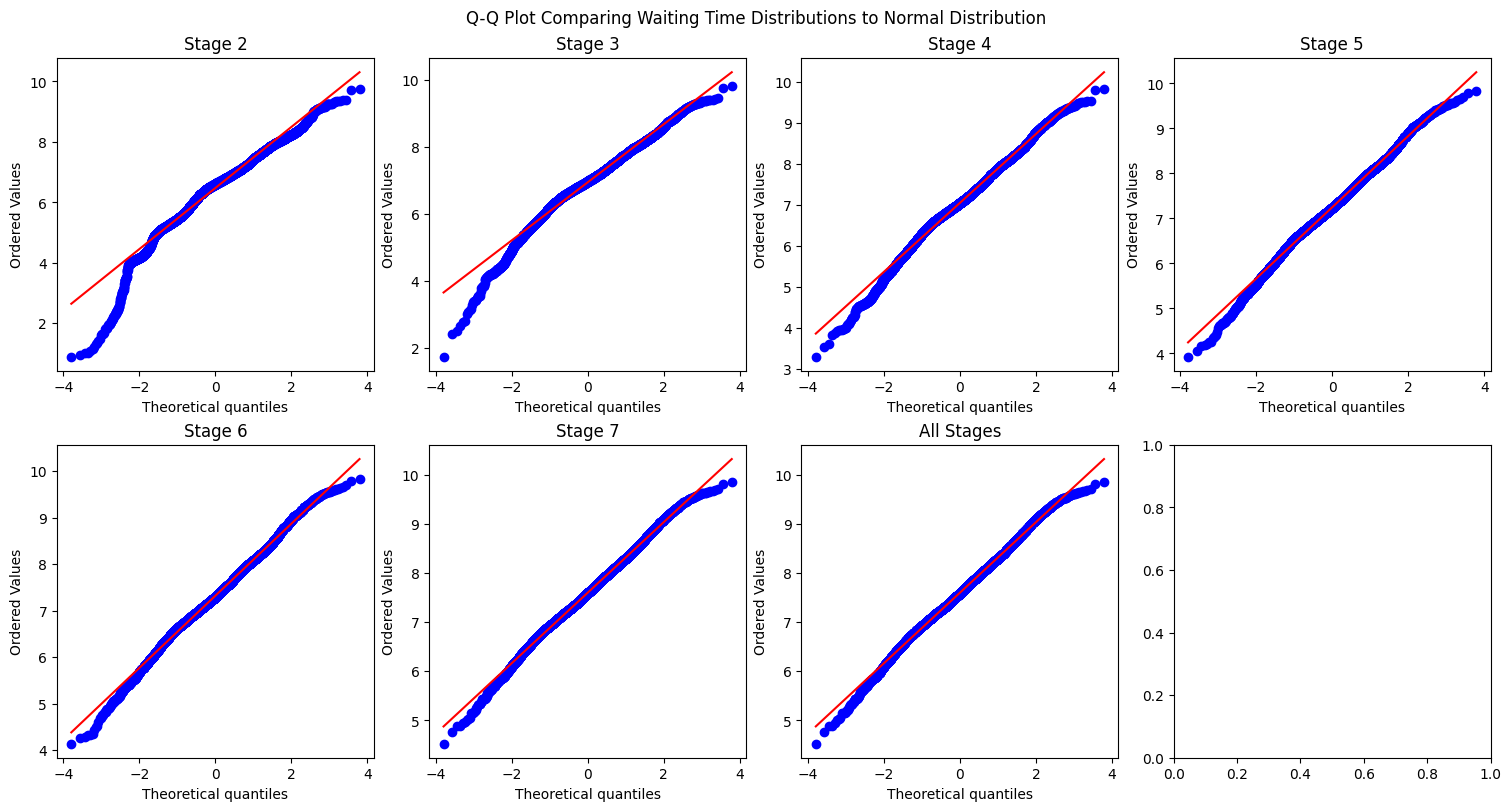

In [91]:
#use log transformed data
#make subplots, add figure size
fig, ax = plt.subplots(2, 4, layout='constrained', figsize=(15, 8))
plt.suptitle('Q-Q Plot Comparing Waiting Time Distributions to Normal Distribution')

#stage 2
probplot(logcsectwo, dist="norm", plot=ax[0, 0])
ax[0, 0].set_title("Stage 2")

#stage 3
probplot(logcsecthree, dist="norm", plot=ax[0, 1])
ax[0, 1].set_title("Stage 3")

#stage 4
probplot(logcsecfour, dist="norm", plot=ax[0, 2])
ax[0, 2].set_title("Stage 4")

#stage 5
probplot(logcsecfive, dist="norm", plot=ax[0, 3])
ax[0, 3].set_title("Stage 5")

#stage 6
probplot(logcsecsix, dist="norm", plot=ax[1, 0])
ax[1, 0].set_title("Stage 6")

#stage 7
probplot(logcsecsev, dist="norm", plot=ax[1, 1])
ax[1, 1].set_title("Stage 7")

#stage all
probplot(logsectot, dist="norm", plot=ax[1, 2])
ax[1, 2].set_title("All Stages")

#save figure and show plots
plt.savefig('Results/qqnormal.png')
plt.show()